# WorldQuant University (22/05) MScFE 690 Capstone (C20-S4)

## Group 33 - POWER SPIKE SWING TRADING STRATEGY

Gaurav Garg – gagarg23@gmail.com
<br>Akash Pramod Kulkarni – akashpk2013@gmail.com 
<br>Derrick Atiase – atiasedelali@gmail.com 

Aug 02, 2022

In [1]:
# Importing the libraries

%matplotlib inline
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date
from datetime import timedelta
from tabulate import tabulate

# Technical Analysis Library
import talib as ta
from talib import MA_Type

# Plotting
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
plt.style.use('seaborn-darkgrid')

# Import and filter warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to calculate all technical data

def technical(data):
    # data: Dataframe containing stock's Open, High, Low, Close price and daily volume
        
    # Bolinger Bands for Volume
    data['up_bb'], data['mid_bb'], data['low_bb'] = ta.BBANDS(data['Volume'], matype=MA_Type.T3)
    
    # To check for volume-spike if volume is greater than upper BBand
    data["vol_spike"] = np.where(data["Volume"]>data["up_bb"],True,False)
    
    # Bolinger Bands for Closing Price
    data['up_bb_c'], data['mid_bb_c'], data['low_bb_c'] = ta.BBANDS(data['Close'],timeperiod=8, matype=MA_Type.T3)
    
    # To calculate BBANDs Signal for Long and Short positions
    data['B_signal'] = np.where((data["vol_spike"]==True) & (data["Low"]<= data["low_bb_c"])  
                              ,-1,(np.where((data["vol_spike"]==True) & (data["High"]>= data["up_bb_c"]),1,0)))
 
    
    # To calculate William %R
    data["WILLR"] = ta.WILLR(data['High'], data['Low'], data['Close'], timeperiod=84)
    
    # To calculate William %R Signal for Long and Short positions
    data["W_signal"] = np.where((data["vol_spike"]==True) & (data["WILLR"]<=-50)  
                              ,-1,(np.where((data["vol_spike"]==True) & (data["WILLR"]>-50 ),1,0)))
    
    # To calculate RSI indicator
    data['RSI'] = ta.RSI(data['Close'],timeperiod=10)
    
    # To calculate RSI indicator signal for Long and Short positions
    data['RSI'] = ta.RSI(data['Close'],timeperiod=14)
    data["SMA55"]=ta.SMA(data["Close"],55)
    data["EMA16"]=ta.EMA(data["Close"],16)
    
    data['R_signal'] = np.where((data["vol_spike"]==True) & (data["EMA16"]>=data["SMA55"]) &
                                ((data["RSI"]<=80)&(data["RSI"]>=25)),1,(np.where((data["vol_spike"]==True) & 
                    (data["EMA16"]<=data["SMA55"]) &((data["RSI"]<=80)&(data["RSI"]>=25)),-1,0)))
 
    
    # To calculate Stochastic indicator
    data['STOCHF'], data['STOCHS'] = ta.STOCH(np.array(data['High']), np.array(data['Low']),
                                     np.array(data['Close']), fastk_period=21, slowk_period=5, slowk_matype=0,
                                     slowd_period=5, slowd_matype=0)
    
    # To calculate Stochastic signal for Long and Short positions
    data['S_signal'] = np.where((data["vol_spike"]==True) & (data["STOCHF"]>data['STOCHS']) &(data['STOCHS']>=50)  
                    ,1,(np.where((data["vol_spike"]==True) & (data["STOCHF"]<data['STOCHS']) &(data['STOCHS']<50),-1,0)))
    
    # To calculate Competitor strategy signal for Long and Short positions
    data["Gap_Up"] = np.where((data["Open"]>data["Open"].shift(1)) & (data["Open"]>data["Close"].shift(1)),True,False)
 
    data["Gap_Down"] = np.where((data["Open"]<data["Open"].shift(1)) & (data["Open"]<data["Close"].shift(1)),True,False)
    data['C_signal'] = np.where(data["vol_spike"]==True,(np.where((data["Gap_Up"]==True)&(data["Close"]>data["Open"]),1,
                                                (np.where((data["Gap_Down"]==True)&(data["Close"]<data["Open"]),-1,0)))),0)
    
    data.dropna(inplace=True)
    return data


In [3]:
# Function to Show the last year Entry Signals for illustration purposes

def entry_display(data,signal):
    # data:Dataframe containing stock's Open, High, Low, Close price and daily volume
    # signal option: "B_signal", "W_signal", "M_signal", "S_signal"
    
    data_plot = data[-252:]
    values = data_plot['Close'].shape[0]

    # Define the plot figure
    plt.figure(figsize=(15, 7))

    # Set the title and axis labels
    plt.title('Entry signals of last one year', fontsize=14)
    plt.xlabel('Days', fontsize=12)
    plt.ylabel('Price', fontsize=12)

    # Plot close price
    plt.plot(range(values), data_plot['Close'])

    # Plot long entry points
    long= np.where((data_plot[signal] == 1), data_plot['Close'], np.nan)

    plt.plot(range(values), long, '^',
             ms=10, label='Long Signal', color='green')

    short =np.where((data_plot[signal] == -1), data_plot['Close'], np.nan)

    plt.plot(range(values), short, '^',
             ms=10, label='Short Signal', color='red')

    plt.legend()

    plt.show()

In [4]:
# Function to exit from Long position

def long_exit(data, exit_date, entry_date, entry_price):
    # Calculate PnL
    pnl = round(np.log(data.loc[exit_date, 'Close']/entry_price), 4)*100
    return pd.DataFrame([('Long',entry_date, entry_price, exit_date, data.loc[exit_date, 'Close'], pnl)])

# Function to exit from Short position

def short_exit(data, exit_date, entry_date, entry_price):
    # Calculate PnL
    pnl = round(np.log(entry_price / data.loc[exit_date, 'Close']), 4)*100
    return pd.DataFrame([('Short',entry_date, entry_price, exit_date, data.loc[exit_date, 'Close'], pnl)])

# Function to Record Entry & Exit

def trade_book(data,signal):
    # data:Dataframe containing stock's Open, High, Low, Close price and daily volume
    # signal option: "B_signal", "W_signal", "M_signal", "S_signal"
    
    # Define the current position and other variables
    current_position = 0
    entry_date = np.nan
    entry_price = np.nan

    trades = pd.DataFrame(columns=range(6))
    i=-1
    # Loop to check the entry and exit logic on each data point
    for date in data.index:
        i=i+1
                    
        # ---------------------------------------------------------------------------------
        # Close open position based on stop loss and profit target
        if current_position == 1:
            # Check for stop loss and profit target
            if ((data.loc[date, 'Low'] < sl)or(data.loc[date,'High']>profit) or ((date-entry_time).days>60)):
                
                trade_details = long_exit(data, date, entry_time, entry_price)
                trades = trades.append(trade_details, ignore_index=True)
                current_position = 0
                
        elif current_position == -1:
            if ((data.loc[date, 'High'] > sl)or(data.loc[date,'Low']<profit)or ((date-entry_time).days>60)):
                
                trade_details = short_exit(data, date, entry_time, entry_price)
                trades = trades.append(trade_details, ignore_index=True)
                current_position = 0
            
        # Long entry point
        elif ((current_position == 0) and (data.loc[date,signal]== 1)):
                current_position = 1
                entry_time = date
                entry_price = data.loc[date, 'Close']
                sl = data.loc[date, "Low"]*.97           # Stop Loss 3% lower
                profit = data.loc[date, 'Close'] + 2*(data.loc[date, 'Close']-sl) # Profit Target twice of expected risk
       
        # Short entry point
        elif ((current_position == 0) and (data.loc[date,signal]== -1)):
                current_position = -1
                entry_time = date
                entry_price = data.loc[date, 'Close']
                sl = data.loc[date, "High"]*1.03       # Stop Loss 3% higher
                profit = data.loc[date, 'Close'] - 2*(sl-data.loc[date, 'Close']) # Profit Target twice of expected risk
               
            
    trades.columns = ['Position','Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'P&L']

    return trades


In [5]:
# Function to analyse backtest

def backtest(data, trade_book):
    back_test = pd.DataFrame(index=['Strategy Backtest'])

    # Startegy start date
    back_test['Start Date'] = data.index[0]

    # Strategy end date
    back_test['End Date'] = data.index[-1]

    # Duration in months
    back_test['Duration (months)'] = "{}".format(
        (back_test['End Date'].iloc[0].year -
         back_test['Start Date'].iloc[0].year) * 12 +
        (back_test['End Date'].iloc[0].month -
         back_test['Start Date'].iloc[0].month))
    
    # Format Start date & End date 
    back_test['Start Date'] = data.index[0].strftime("%Y-%m-%d")
    back_test['End Date'] = data.index[-1].strftime("%Y-%m-%d")
    
    # Number of trades
    back_test['Number of Trades'] = trade_book.shape[0]

    # Holding time
    trade_book['Holding Days'] = (trade_book['Exit Time'] - trade_book['Entry Time'])
    back_test['Avg holding Days'] = (trade_book['Holding Days'].mean()).days
    back_test['Med holding Days'] = (trade_book['Holding Days'].median()).days
    back_test['Max holding Days'] = (trade_book['Holding Days'].max()).days
    back_test['Min holding Days'] = (trade_book['Holding Days'].min()).days
    
    display(back_test.astype(object).T)
  

In [6]:
# Function to calculate risk & return metrices

def risk_return(data, trade_book):
    import monthly_returns_heatmap as mrh
    
    risk_return_metrics = pd.DataFrame(index=['Risk & Returns Metric'])
    price_data = data
    # ---------------------Positions---------------------
    # Add the positions to the price_data based on the trade book
    price_data['positions'] = np.nan
    for i in trade_book.index:
        time = trade_book["Entry Time"][i]
        if trade_book["Position"][i]=="Long":
            price_data.loc[time,'positions'] = 1
        elif trade_book["Position"][i]=="Short":
            price_data.loc[time,'positions'] = -1
    price_data.loc[list(trade_book['Exit Time']), 'positions'] = 0
    price_data['positions'].ffill(inplace=True)

    # ---------------------Profit & Loss---------------------
    # Add the PnL column based on the trade book
    price_data['P&L'] = 0
    price_data.loc[list(trade_book['Entry Time']), 'P&L'] = trade_book['P&L'].values

    # ---------------------Strategy returns---------------------
    # Calculate the strategy returns
    
    price_data['strategy_returns'] = price_data['positions'].shift(1) * \
                                     price_data['Close'].pct_change()

    # ---------------------Cumulative returns---------------------
    # Calculate the cumulative returns
    
    price_data['cumulative_returns'] = (1+price_data['strategy_returns']).cumprod()
    risk_return_metrics['Cumulative Return'] = "{0:.2f}%".format((price_data['cumulative_returns'][-1] - 1)*100)

    # ---------------------Annualised return---------------------
    risk_return_metrics['Annualised Return'] = "{0:.2f}%".format(((price_data['cumulative_returns'][-1]) **
                                           (252/price_data.shape[0]) - 1) * 100)

    # ---------------------Annualised volatility---------------------
    risk_return_metrics['Annualised Volatility'] = "{0:.2f}%".format(
        price_data['strategy_returns'].std()*np.sqrt(252) * 100)
    
        
    # ---------------------Max drawdown---------------------
    # Calculate the running maximum
    running_max = np.maximum.accumulate(price_data['cumulative_returns'].dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = ((price_data['cumulative_returns'])/running_max - 1) * 100

    # Calculate the maximum drawdown
    risk_return_metrics['Maximum Drawdown'] = "{0:.2f}%".format(drawdown.min())

        
    # ---------------------Win rate %---------------------
    count_of_profit = price_data[price_data['P&L'] > 0]['P&L'].count()
    count_of_loss = price_data[price_data['P&L'] < 0]['P&L'].count()
    risk_return_metrics['Win Rate'] = round((count_of_profit /(count_of_profit+count_of_loss)) * 100,2)
    
    # ---------------------Profit factor---------------------
    sum_of_profit = price_data[price_data['P&L'] > 0]['P&L'].sum()
    sum_of_loss = -price_data[price_data['P&L'] < 0]['P&L'].sum()
    risk_return_metrics['Profit Factor'] = round(sum_of_profit / sum_of_loss,2)

    # ---------------------Sharpe Ratio---------------------
    risk_return_metrics['Sharpe Ratio'] = round(price_data['strategy_returns'].mean()/
                   price_data['strategy_returns'].std() * np.sqrt(252), 2)
    
    
    # -------------Heatmap of month vs year returns--------------
    fig = plt.figure(figsize=(10, 7))
    mrh.plot(price_data['strategy_returns'])
    plt.tight_layout()
    plt.show()

    # ---------------------Return Curve---------------------
    # Plot cumulative strategy returns
    price_data['cumulative_returns'] = (price_data['cumulative_returns']-1)*100
    price_data['cumulative_returns'].plot(figsize=(10, 7), color='green')
    # Restore data
    price_data['cumulative_returns'] = ((price_data['cumulative_returns']/100)+1)
    plt.title('Cumulative Returns Curve', fontsize=14)
    plt.ylabel('Cumulative returns(%)')
    plt.tight_layout()
    plt.show()
    
    

    # ---------------------Rolling estimation of volatility---------------------
    window_size = 21
    price_data['rolling_volatility'] = price_data['strategy_returns'].rolling(
        window_size).std() * np.sqrt(252) * 100
    price_data['rolling_volatility'].plot(figsize=(10,7), color='green')
    plt.title('21 Days Rolling Volatility', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Volatility', fontsize=12)
    plt.tight_layout()
    plt.show()

    
    # ---------------------Drawdown plot---------------------
    fig = plt.figure(figsize=(10, 7))

    # Plot max drawdown
    plt.plot(drawdown, color='red')
    # Fill in-between the drawdown
    plt.fill_between(drawdown.index, drawdown.values, color='red')
    plt.title('Strategy Drawdown', fontsize=14)
    plt.ylabel('Drawdown(%)', fontsize=12)
    plt.xlabel('Year', fontsize=12)

    plt.tight_layout()
    plt.show()

    display(risk_return_metrics.astype(object).T)
   

In [7]:
# Function to analyse the strategy
def strategy_analysis(data, signal):
    entry_display(data,signal)
    trd = trade_book(data,signal)
    backtest(data, trd)
    risk_return(data, trd)
        

In [8]:
# Lets select Top Four Constituents by Weightage of NIFTY50 Index of INDIA for backtesting our strategies

print("\nTop Four Constituents by Weightage of NIFTY50 Index of INDIA:\n")
w_table = [['Company’s Name','Sector','Weight%'],
           ['Reliance Industries Ltd.','Refineries',12.94],
           ['HDFC Bank Ltd.','Finance - Banks - Private Sector',08.55],
           ['Infosys Ltd.','IT Consulting & Software',07.73],
           ['ICICI Bank Ltd.','Finance - Banks - Private Sector',07.11]]

print(tabulate(w_table,headers='firstrow',tablefmt='fancy_grid',showindex=range(1,5)))


Top Four Constituents by Weightage of NIFTY50 Index of INDIA:

╒════╤══════════════════════════╤══════════════════════════════════╤═══════════╕
│    │ Company’s Name           │ Sector                           │   Weight% │
╞════╪══════════════════════════╪══════════════════════════════════╪═══════════╡
│  1 │ Reliance Industries Ltd. │ Refineries                       │     12.94 │
├────┼──────────────────────────┼──────────────────────────────────┼───────────┤
│  2 │ HDFC Bank Ltd.           │ Finance - Banks - Private Sector │      8.55 │
├────┼──────────────────────────┼──────────────────────────────────┼───────────┤
│  3 │ Infosys Ltd.             │ IT Consulting & Software         │      7.73 │
├────┼──────────────────────────┼──────────────────────────────────┼───────────┤
│  4 │ ICICI Bank Ltd.          │ Finance - Banks - Private Sector │      7.11 │
╘════╧══════════════════════════╧══════════════════════════════════╧═══════════╛


In [9]:
# To download & Prepare the data

# For Reliance Industries Ltd
data_reliance = yf.download("RELIANCE.NS", start="2016-01-01",end="2020-12-31",
                 auto_adjust = True)
data_reliance = technical(data_reliance)

# For HDFC Bank
data_hdfcbank = yf.download("HDFCBANK.NS", start="2016-01-01",end="2020-12-31",
                 auto_adjust = True)
data_hdfcbank = technical(data_hdfcbank)

# For Infosys Ltd
data_infy = yf.download("INFY.NS", start="2016-01-01",end="2020-12-31",
                 auto_adjust = True)
data_infy = technical(data_infy)

# For ICICI Bank
data_icicibank = yf.download("ICICIBANK.NS", start="2016-01-01",end="2020-12-31",
                 auto_adjust = True)
data_icicibank = technical(data_icicibank)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



-------------------------------------------------------------------
Strategies Analysis for Reliance Industries
-------------------------------------------------------------------


BolingerBands strategy with Power Spike for Reliance Industries
---------------------------------------------------------------------



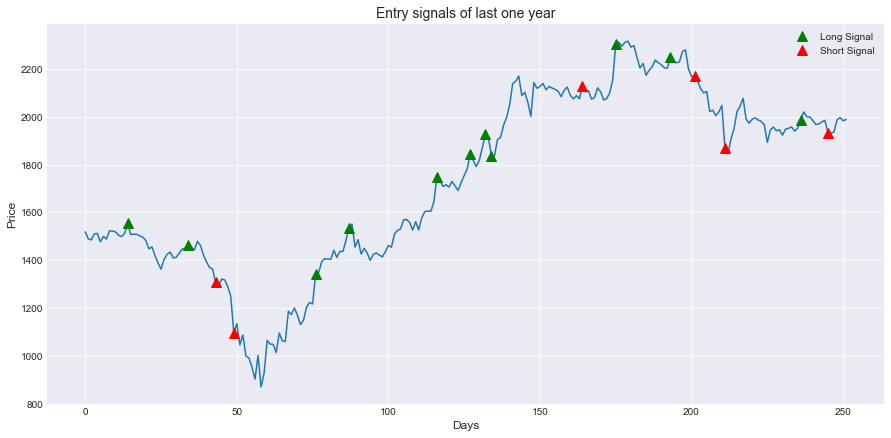

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 34
Avg holding Days                 26
Med holding Days                 18
Max holding Days                 61
Min holding Days                  6

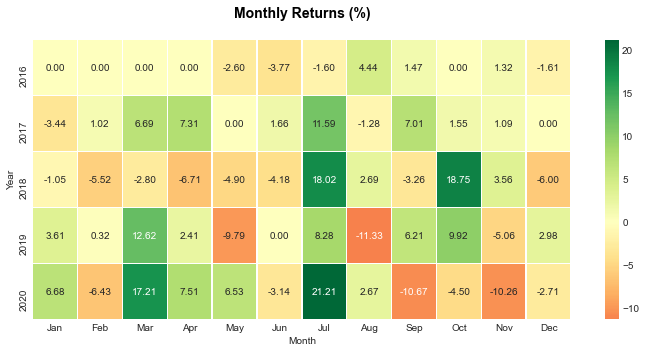

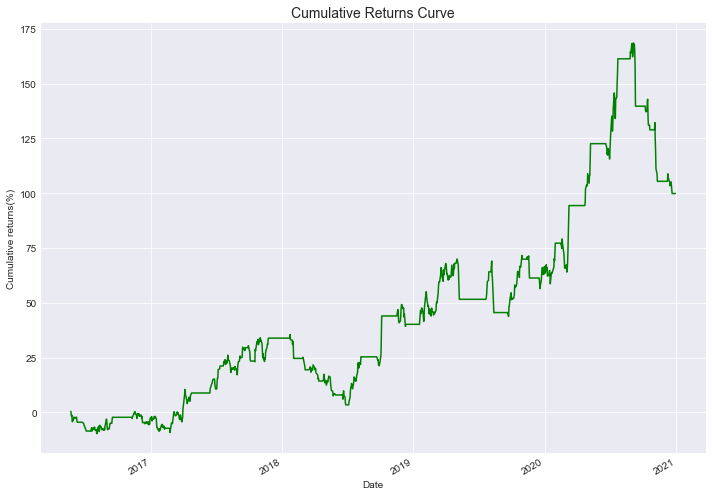

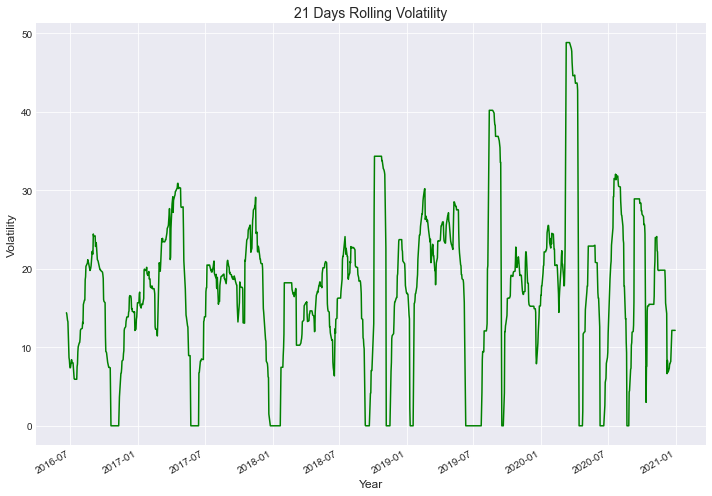

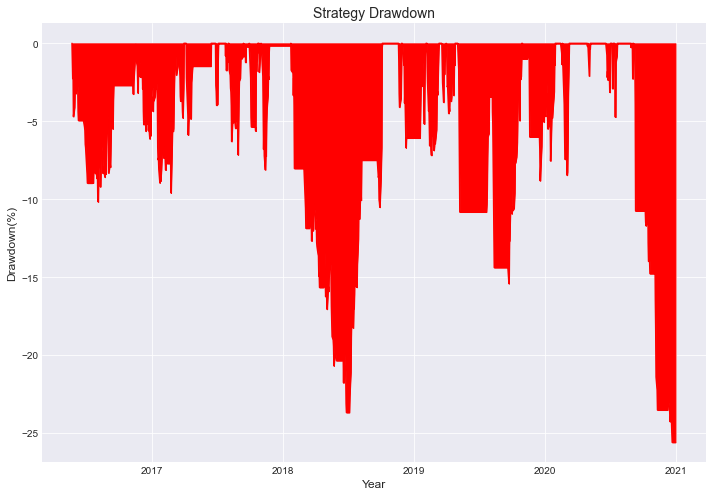

Risk & Returns Metric
Cumulative Return                    99.88%
Annualised Return                    16.39%
Annualised Volatility                19.78%
Maximum Drawdown                    -25.59%
Win Rate                              44.12
Profit Factor                          1.76
Sharpe Ratio                           0.87


William %R strategy with Power Spike for Reliance Industries
---------------------------------------------------------------------



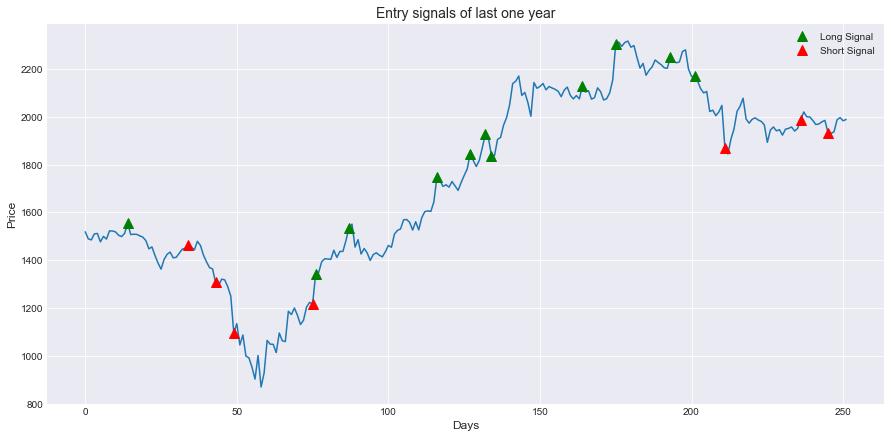

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 36
Avg holding Days                 28
Med holding Days                 24
Max holding Days                 61
Min holding Days                  1

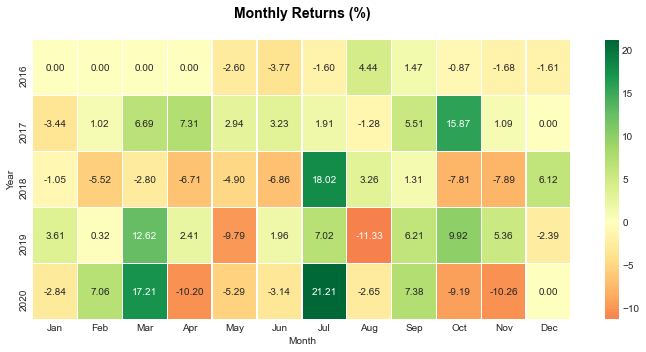

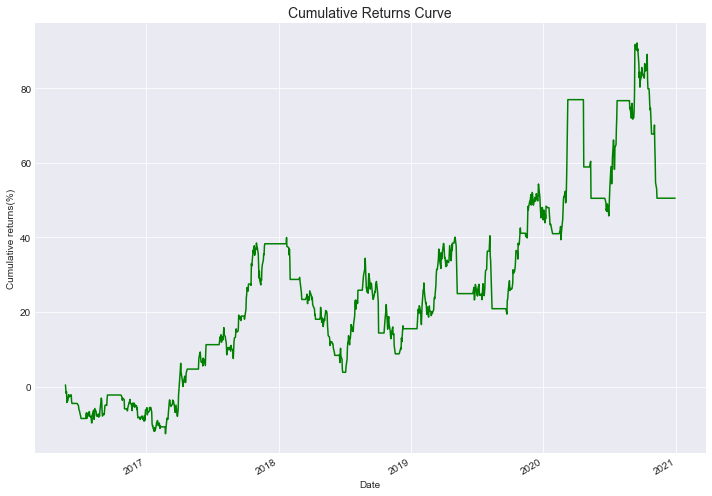

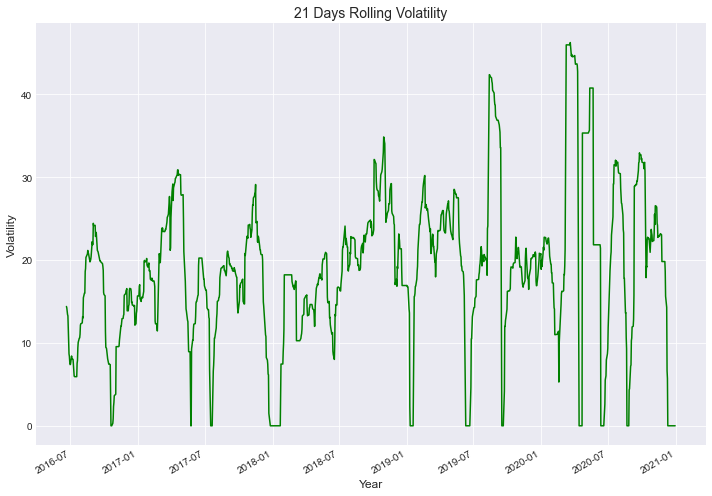

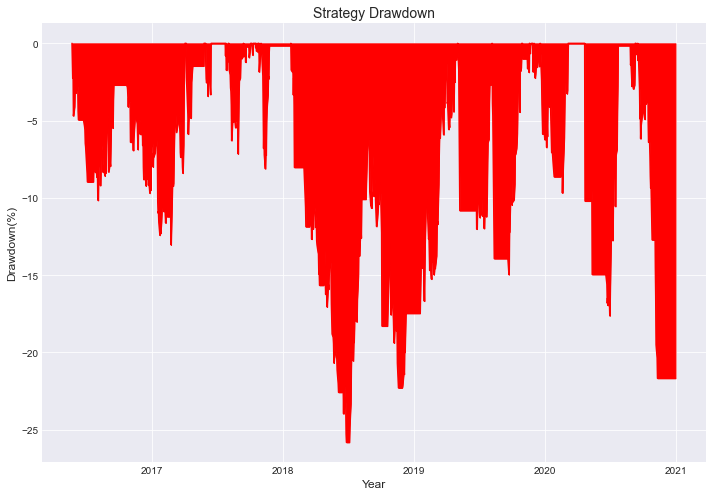

Risk & Returns Metric
Cumulative Return                    50.52%
Annualised Return                     9.37%
Annualised Volatility                20.99%
Maximum Drawdown                    -25.81%
Win Rate                              44.44
Profit Factor                          1.43
Sharpe Ratio                           0.54


Stochastic Oscillator strategy with Power Spike for Reliance Industries
---------------------------------------------------------------------



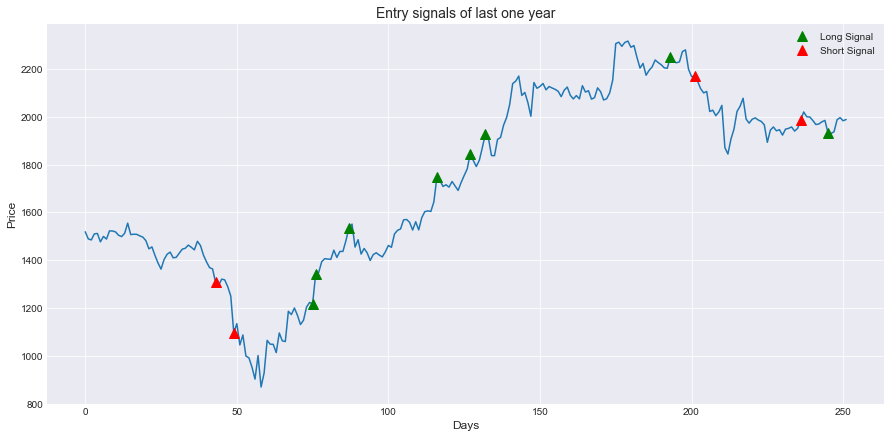

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 24
Avg holding Days                 26
Med holding Days                 20
Max holding Days                 61
Min holding Days                  3

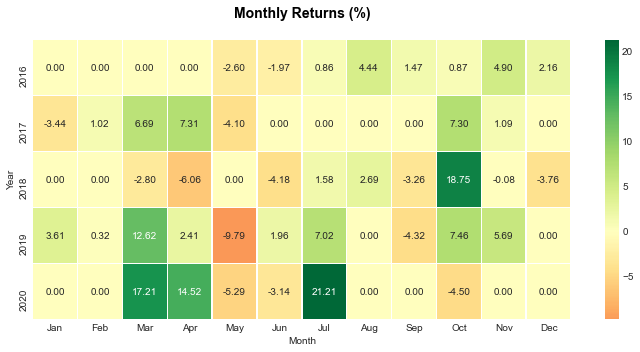

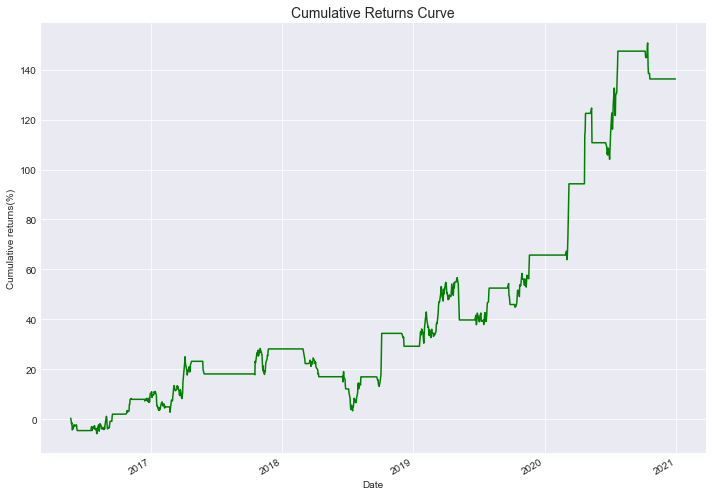

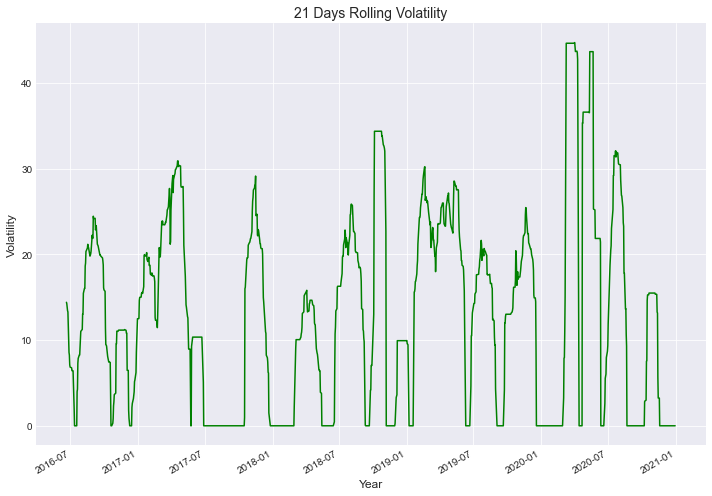

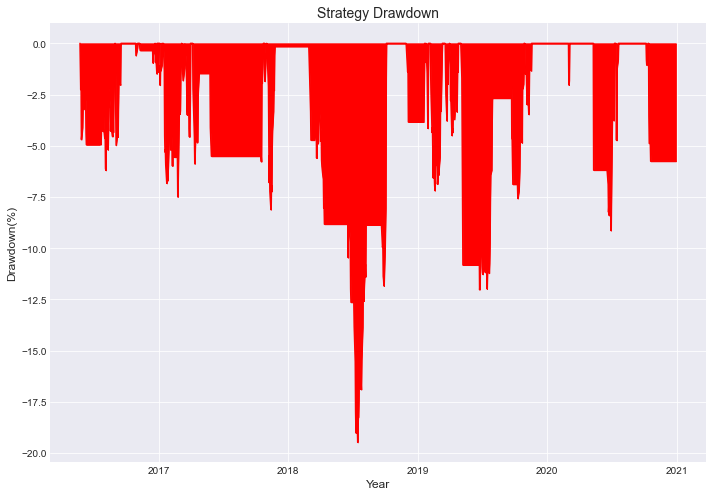

Risk & Returns Metric
Cumulative Return                   136.25%
Annualised Return                    20.73%
Annualised Volatility                17.32%
Maximum Drawdown                    -19.47%
Win Rate                               50.0
Profit Factor                          2.63
Sharpe Ratio                           1.18


RSI Indicator strategy with Power Spike for Reliance Industries
---------------------------------------------------------------------



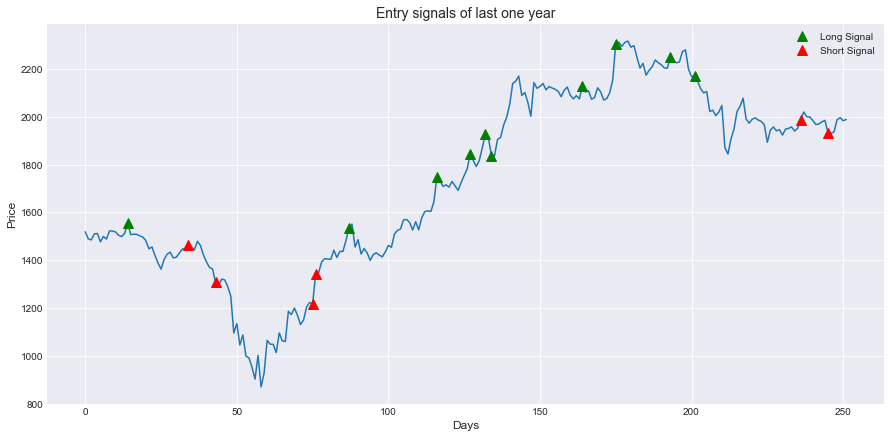

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 39
Avg holding Days                 23
Med holding Days                 14
Max holding Days                 61
Min holding Days                  1

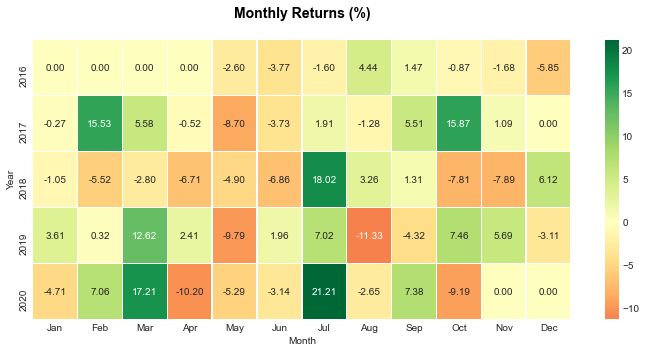

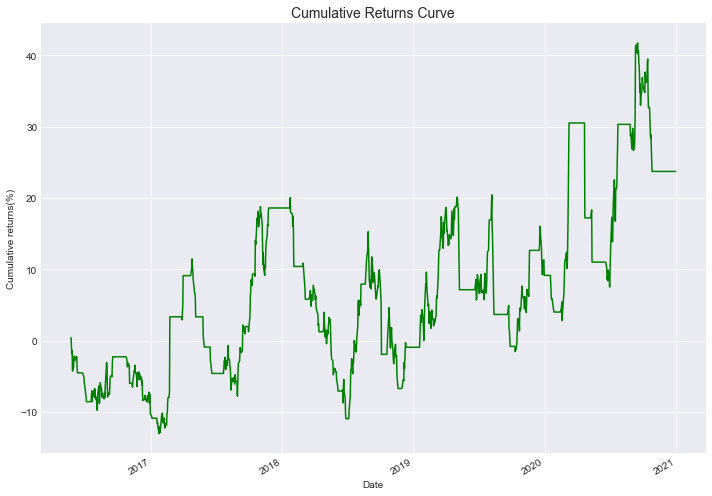

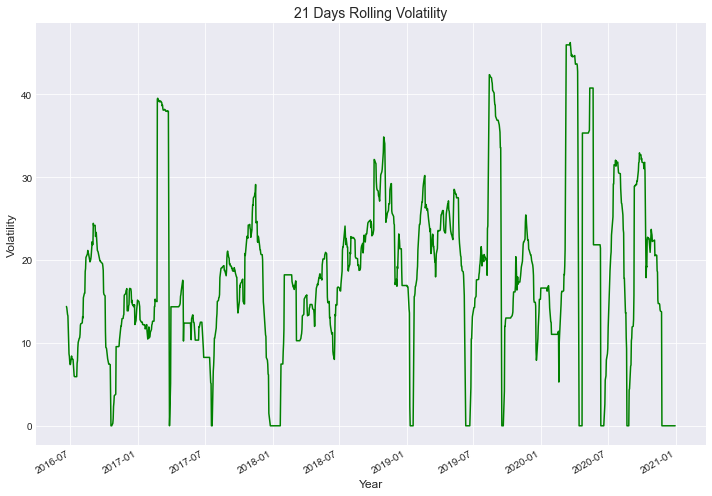

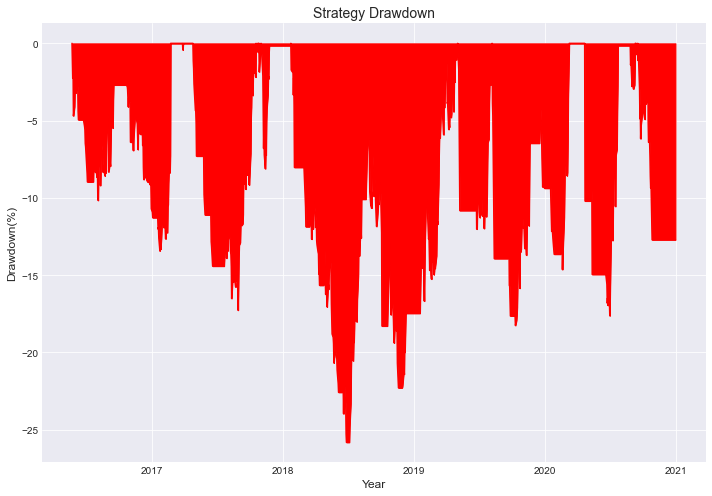

Risk & Returns Metric
Cumulative Return                    23.73%
Annualised Return                     4.78%
Annualised Volatility                20.56%
Maximum Drawdown                    -25.81%
Win Rate                              38.46
Profit Factor                          1.23
Sharpe Ratio                           0.33


Power Spike Competitor strategy for Reliance Industries
---------------------------------------------------------------------



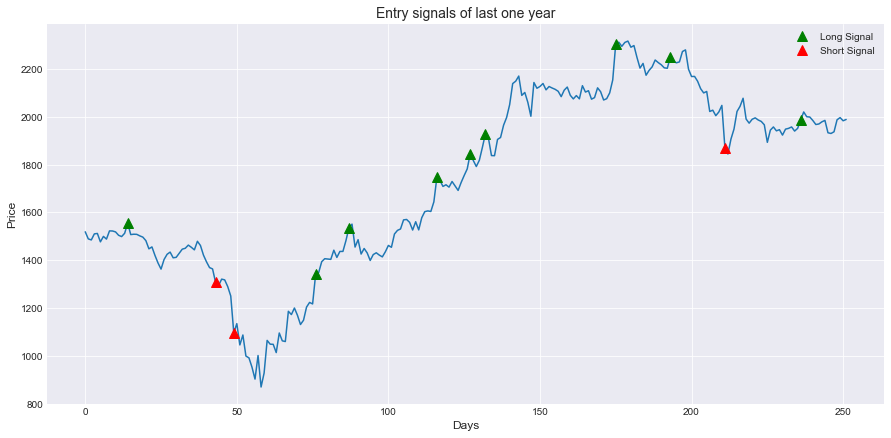

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 21
Avg holding Days                 31
Med holding Days                 28
Max holding Days                 62
Min holding Days                  8

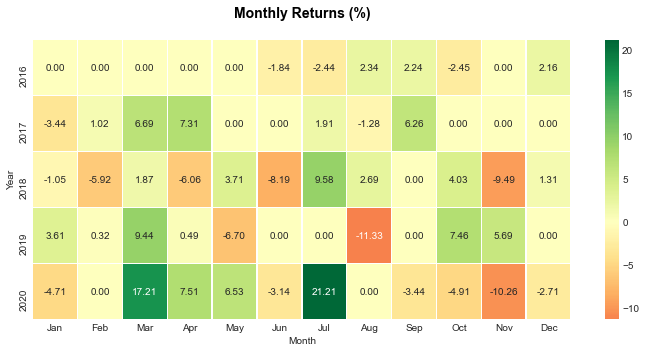

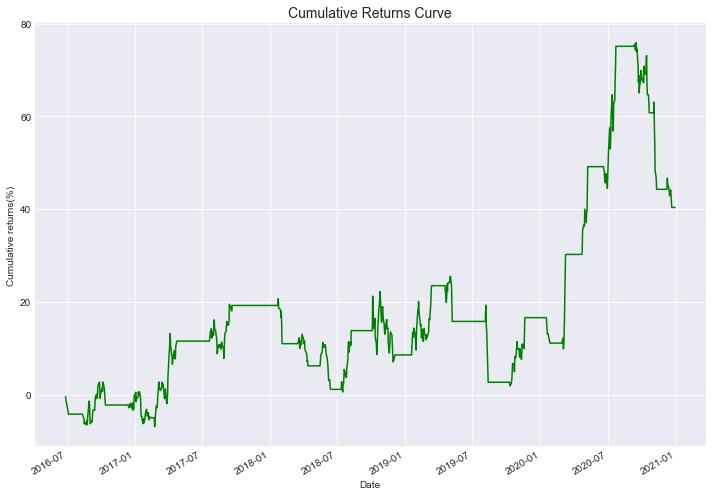

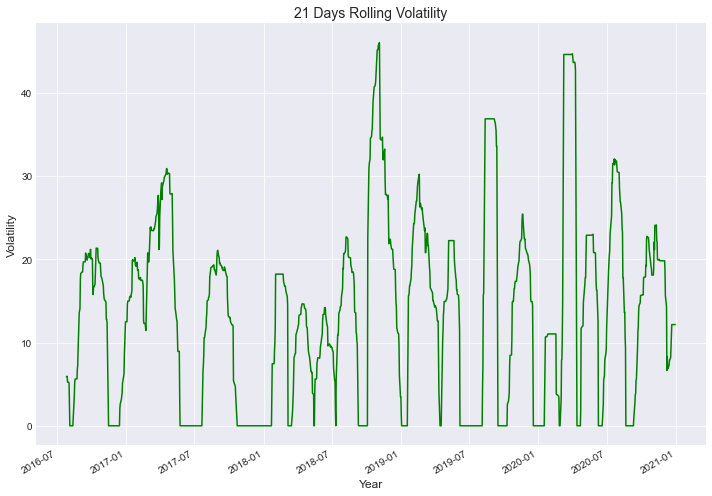

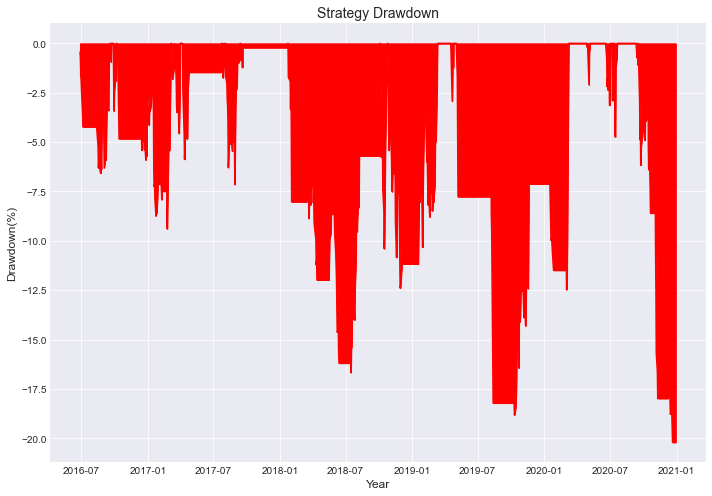

Risk & Returns Metric
Cumulative Return                    40.35%
Annualised Return                     7.71%
Annualised Volatility                17.62%
Maximum Drawdown                    -20.21%
Win Rate                              42.86
Profit Factor                          1.57
Sharpe Ratio                           0.52

In [10]:
print("\n-------------------------------------------------------------------")
print("Strategies Analysis for Reliance Industries")
print("-------------------------------------------------------------------\n")

# To analyse BolingerBands strategy with Power Spike for Reliance Industries
print("\nBolingerBands strategy with Power Spike for Reliance Industries")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_reliance, "B_signal")

# To analyse William %R strategy with Power Spike for Reliance Industries
print("\nWilliam %R strategy with Power Spike for Reliance Industries")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_reliance, "W_signal")

# To analyse Stochastic oscillator strategy with Power Spike for Reliance Industries
print("\nStochastic Oscillator strategy with Power Spike for Reliance Industries")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_reliance, "S_signal")

# To analyse RSI indicator strategy with Power Spike for Reliance Industries
print("\nRSI Indicator strategy with Power Spike for Reliance Industries")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_reliance, "R_signal")

# To analyse Power Spike Competitor strategy for Reliance Industries
print("\nPower Spike Competitor strategy for Reliance Industries")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_reliance, "C_signal")


-------------------------------------------------------------------
Strategies Analysis for HDFC BANK
-------------------------------------------------------------------


BolingerBands strategy with Power Spike for HDFC BANK
---------------------------------------------------------------------



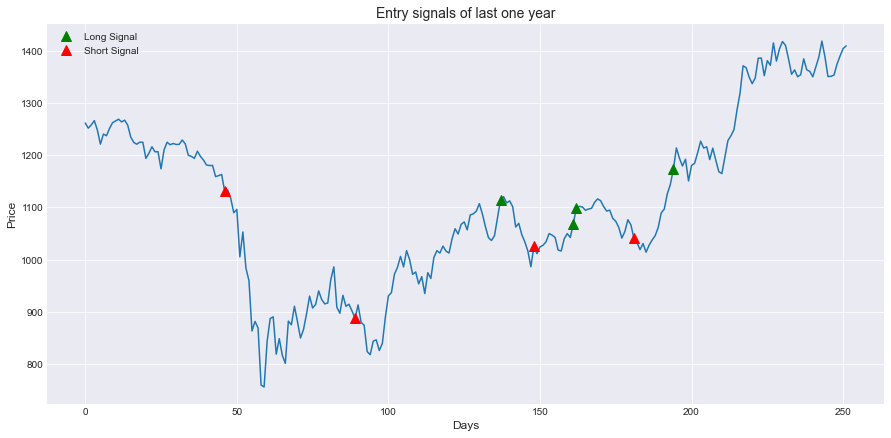

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 25
Avg holding Days                 34
Med holding Days                 32
Max holding Days                 62
Min holding Days                  1

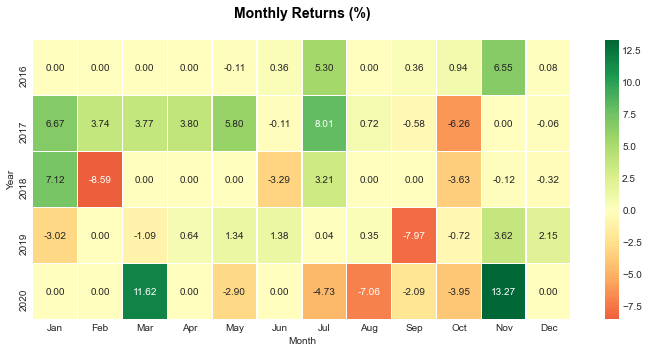

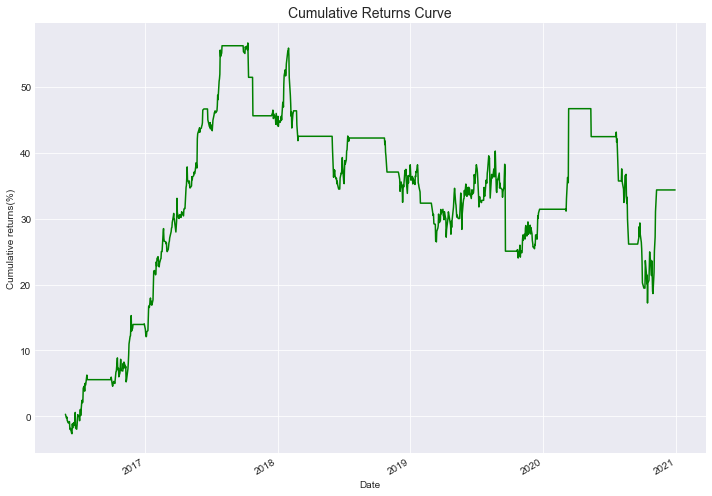

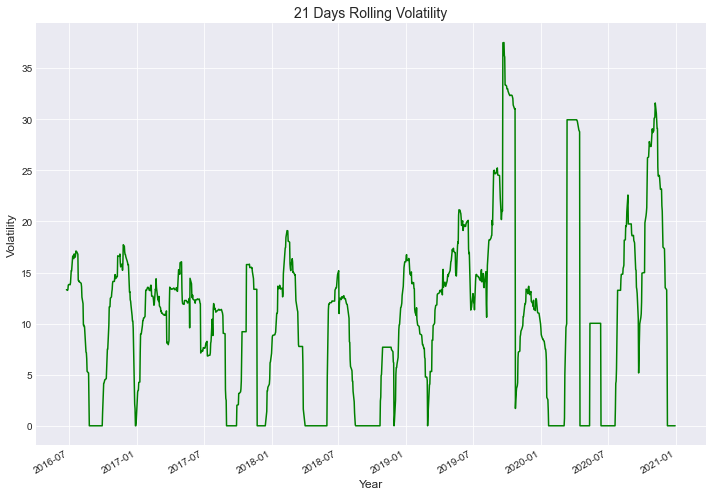

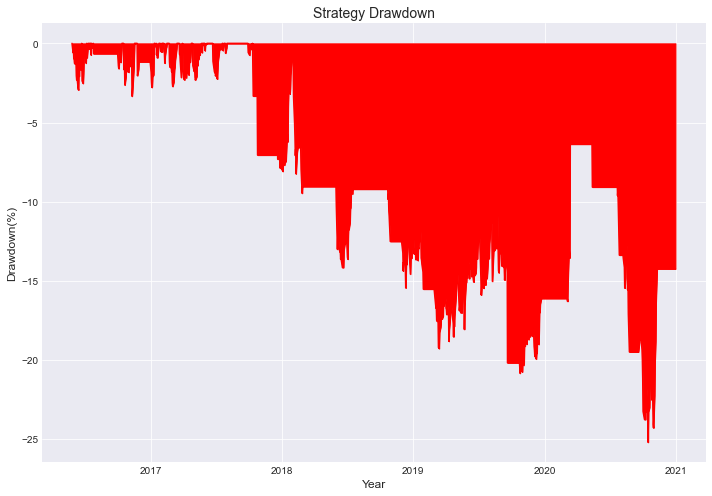

Risk & Returns Metric
Cumulative Return                    34.36%
Annualised Return                     6.69%
Annualised Volatility                13.21%
Maximum Drawdown                    -25.20%
Win Rate                               52.0
Profit Factor                          1.64
Sharpe Ratio                           0.56


William %R strategy with Power Spike for HDFC BANK
---------------------------------------------------------------------



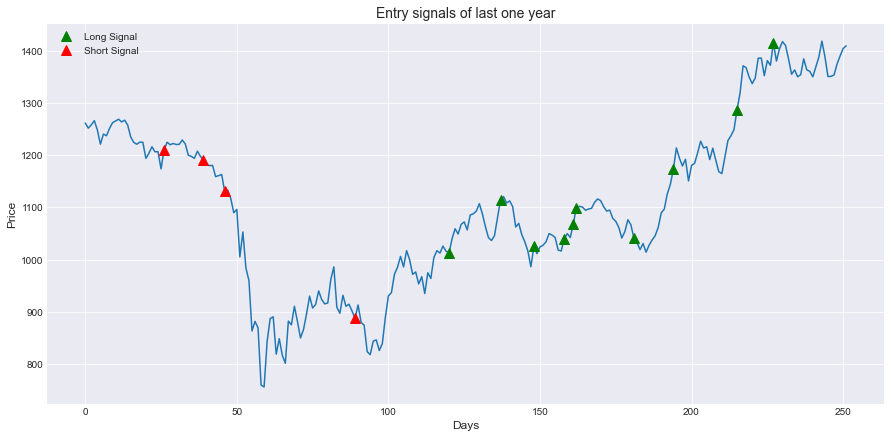

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 29
Avg holding Days                 31
Med holding Days                 29
Max holding Days                 62
Min holding Days                  1

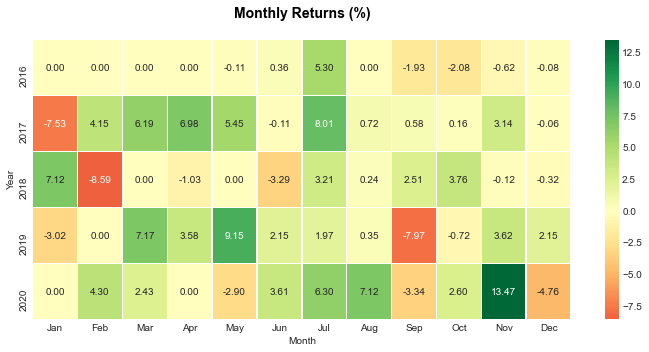

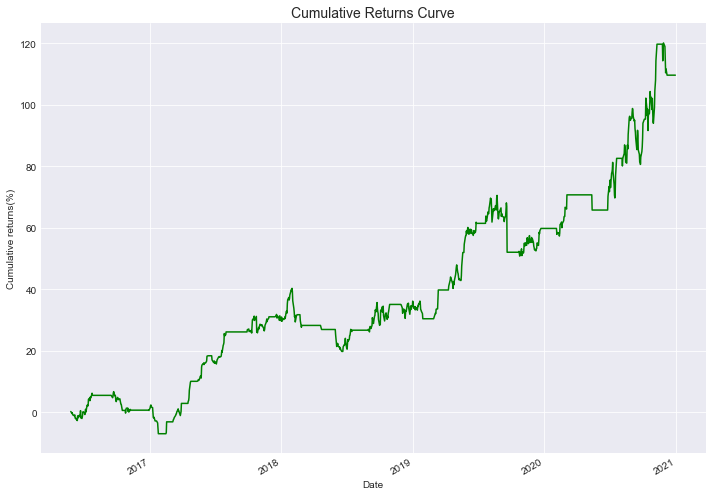

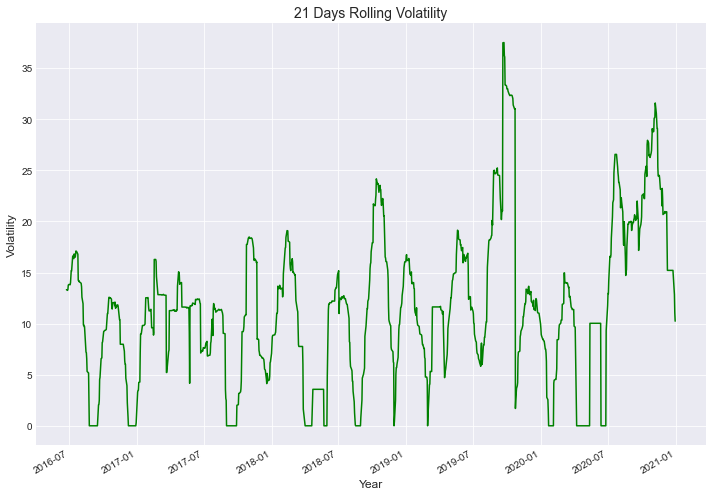

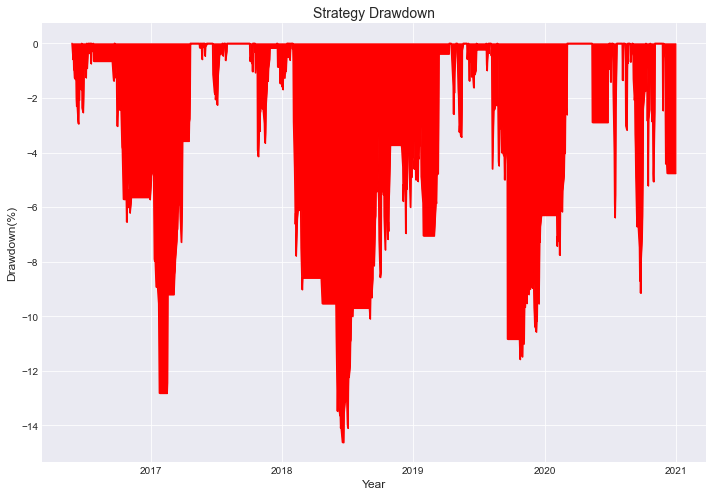

Risk & Returns Metric
Cumulative Return                   109.69%
Annualised Return                    17.62%
Annualised Volatility                13.56%
Maximum Drawdown                    -14.62%
Win Rate                              65.52
Profit Factor                          3.04
Sharpe Ratio                           1.28


Stochastic Oscillator strategy with Power Spike for HDFC BANK
---------------------------------------------------------------------



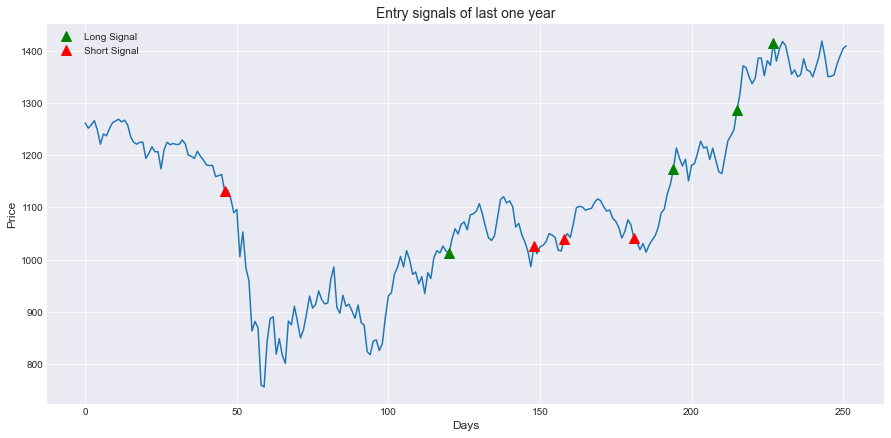

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 23
Avg holding Days                 36
Med holding Days                 35
Max holding Days                 63
Min holding Days                  1

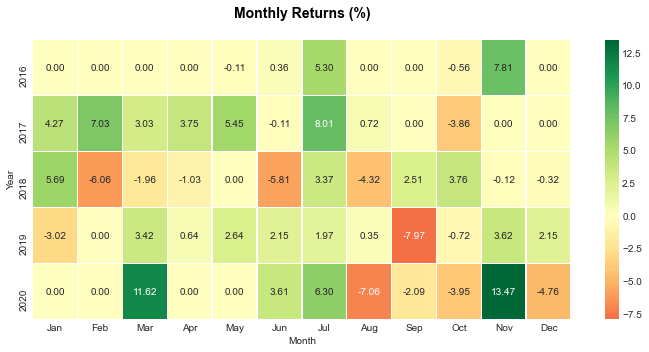

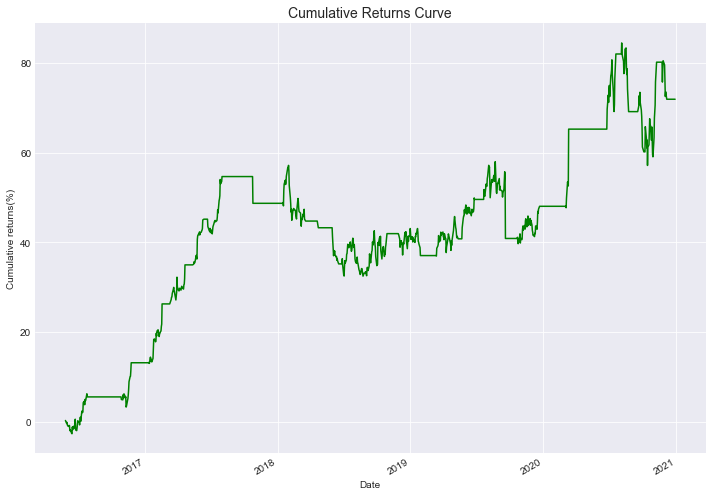

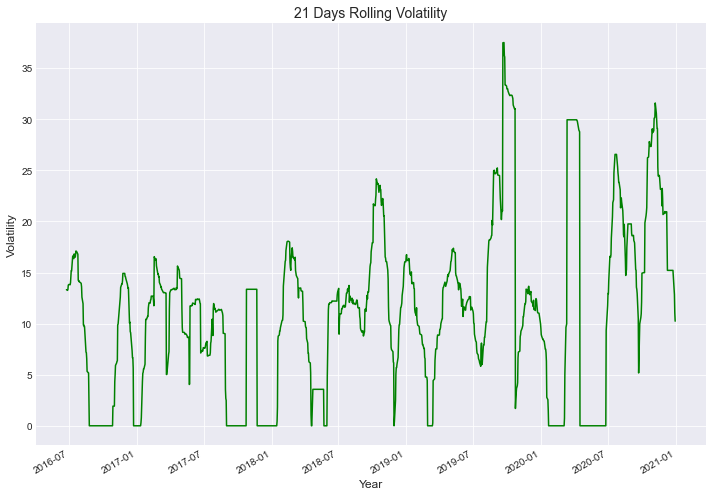

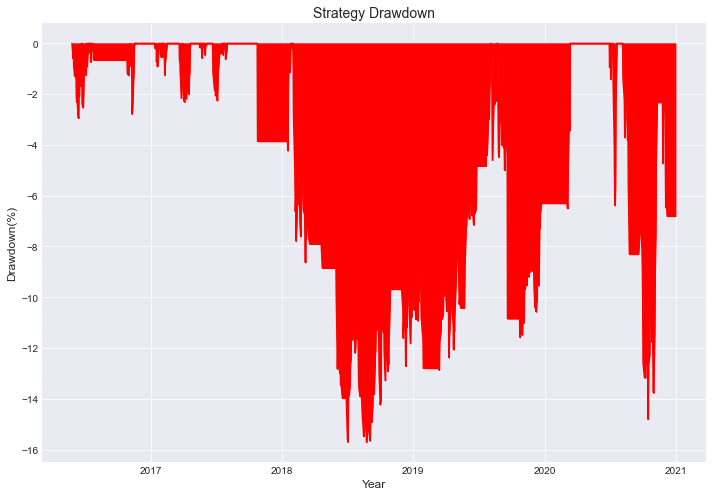

Risk & Returns Metric
Cumulative Return                    71.92%
Annualised Return                    12.61%
Annualised Volatility                13.61%
Maximum Drawdown                    -15.71%
Win Rate                              56.52
Profit Factor                          2.44
Sharpe Ratio                           0.95


RSI Indicator strategy with Power Spike for HDFC BANK
---------------------------------------------------------------------



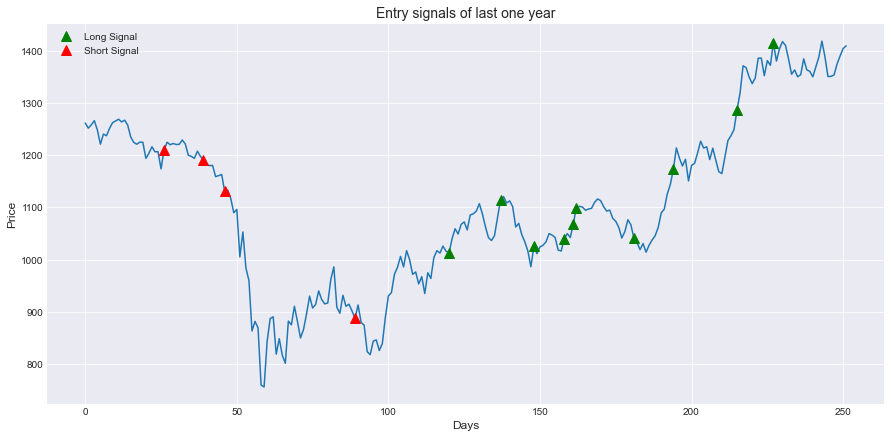

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 28
Avg holding Days                 36
Med holding Days                 31
Max holding Days                 62
Min holding Days                  1

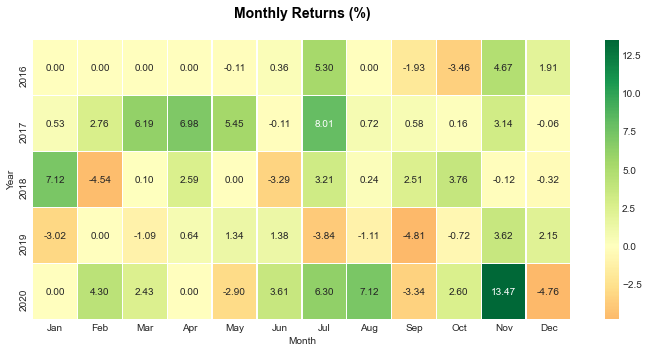

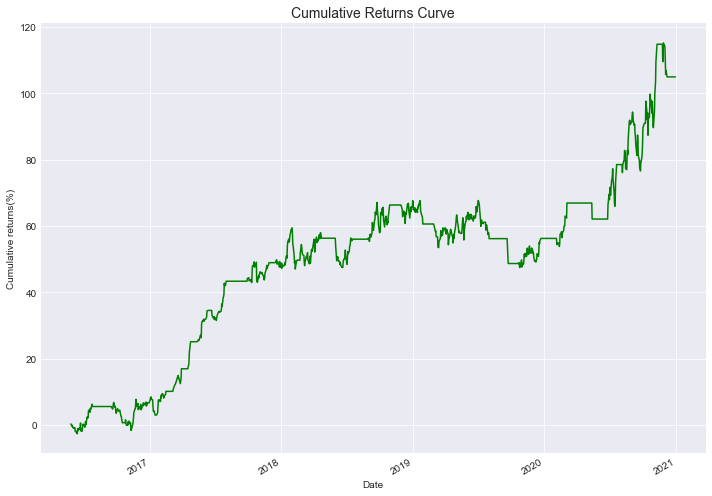

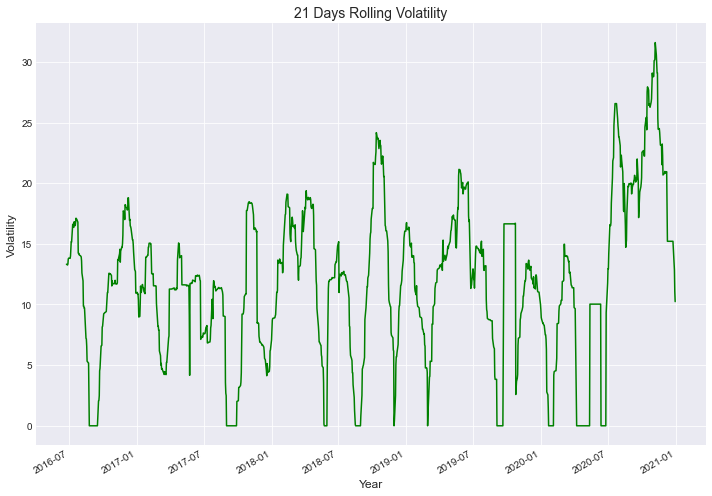

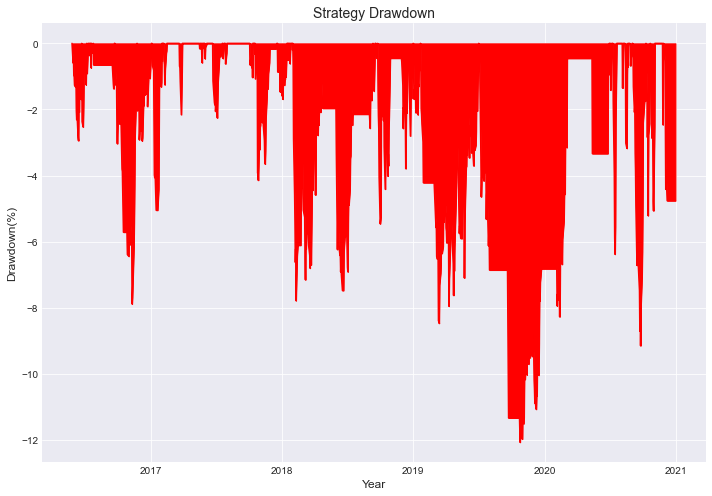

Risk & Returns Metric
Cumulative Return                   105.00%
Annualised Return                    17.03%
Annualised Volatility                13.35%
Maximum Drawdown                    -12.07%
Win Rate                              67.86
Profit Factor                          2.97
Sharpe Ratio                           1.26


Power Spike Competitor strategy for HDFC BANK
---------------------------------------------------------------------



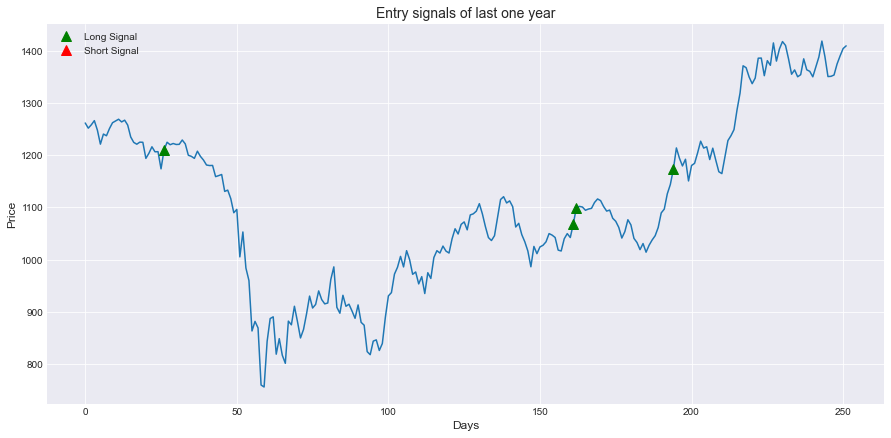

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 17
Avg holding Days                 42
Med holding Days                 45
Max holding Days                 61
Min holding Days                  1

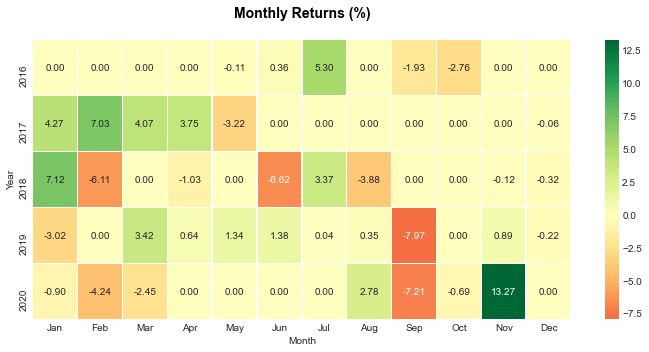

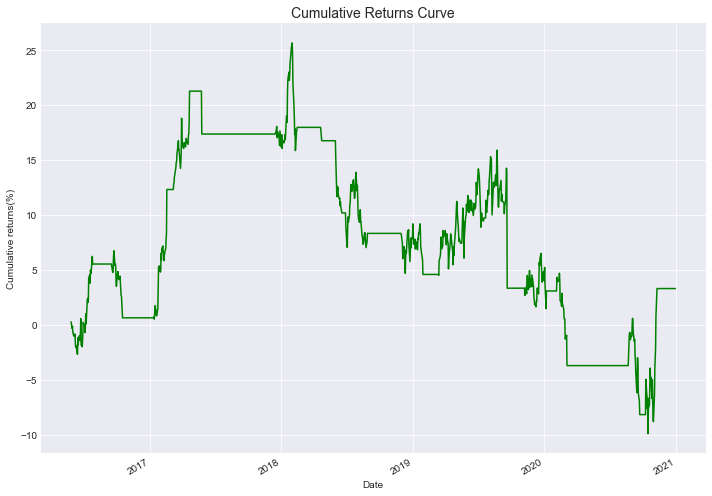

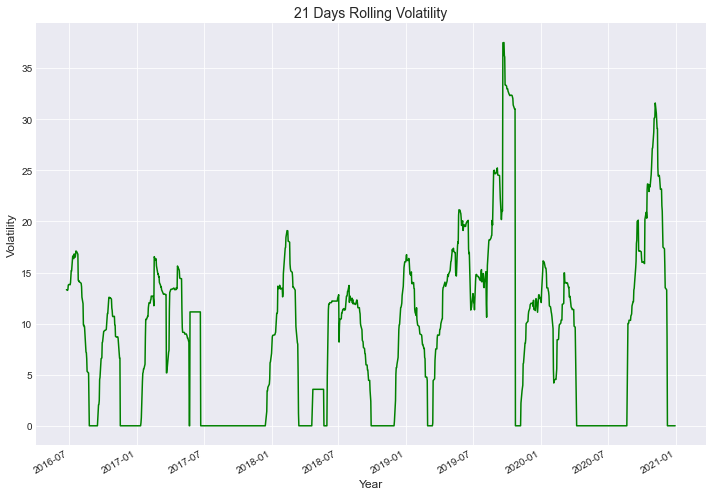

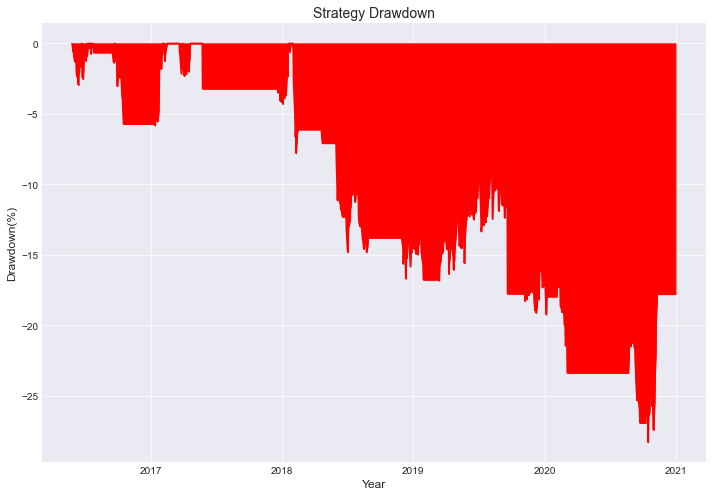

Risk & Returns Metric
Cumulative Return                     3.32%
Annualised Return                     0.72%
Annualised Volatility                11.69%
Maximum Drawdown                    -28.28%
Win Rate                              41.18
Profit Factor                          1.13
Sharpe Ratio                           0.12

In [11]:
print("\n-------------------------------------------------------------------")
print("Strategies Analysis for HDFC BANK")
print("-------------------------------------------------------------------\n")

# To analyse BolingerBands strategy with Power Spike for HDFC BANK
print("\nBolingerBands strategy with Power Spike for HDFC BANK")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_hdfcbank, "B_signal")

# To analyse William %R strategy with Power Spike for HDFC BANK
print("\nWilliam %R strategy with Power Spike for HDFC BANK")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_hdfcbank, "W_signal")

# To analyse Stochastic oscillator strategy with Power Spike for HDFC BANK
print("\nStochastic Oscillator strategy with Power Spike for HDFC BANK")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_hdfcbank, "S_signal")

# To analyse RSI indicator strategy with Power Spike for HDFC BANK
print("\nRSI Indicator strategy with Power Spike for HDFC BANK")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_hdfcbank, "R_signal")

# To analyse Power Spike Competitor strategy for HDFC BANK
print("\nPower Spike Competitor strategy for HDFC BANK")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_hdfcbank, "C_signal")


-------------------------------------------------------------------
Strategies Analysis for INFOSYS
-------------------------------------------------------------------


BolingerBands strategy with Power Spike for INFOSYS
---------------------------------------------------------------------



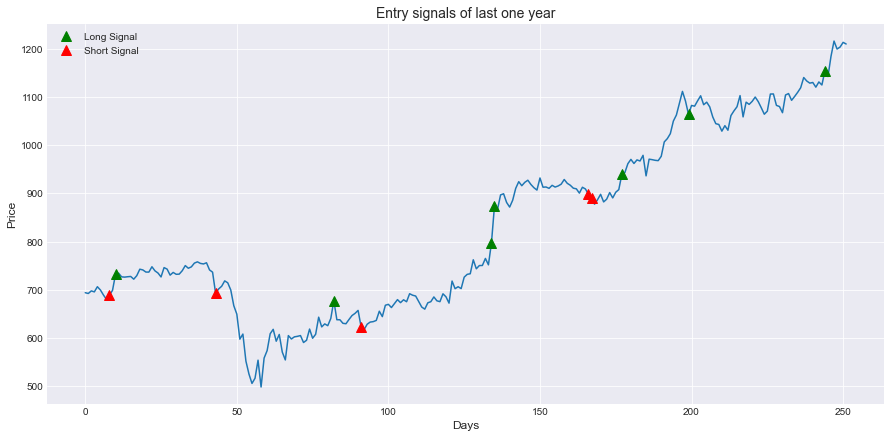

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 32
Avg holding Days                 26
Med holding Days                 16
Max holding Days                 63
Min holding Days                  1

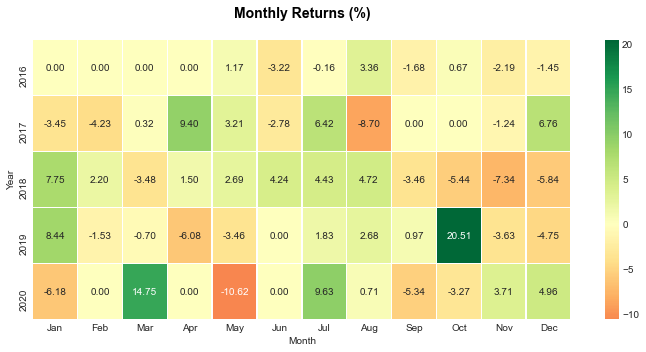

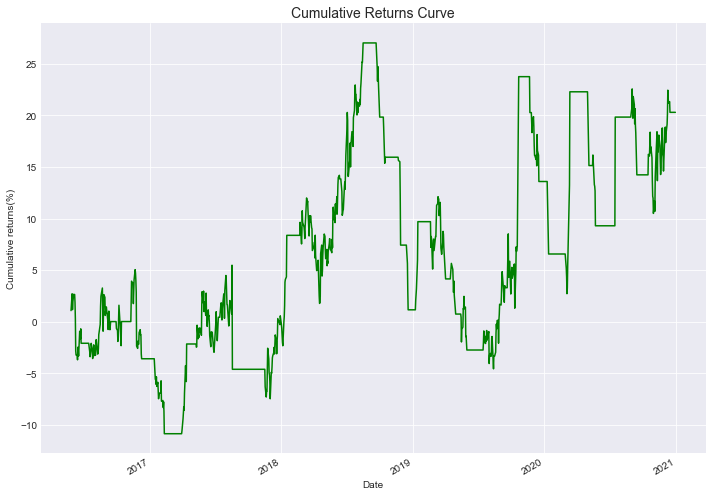

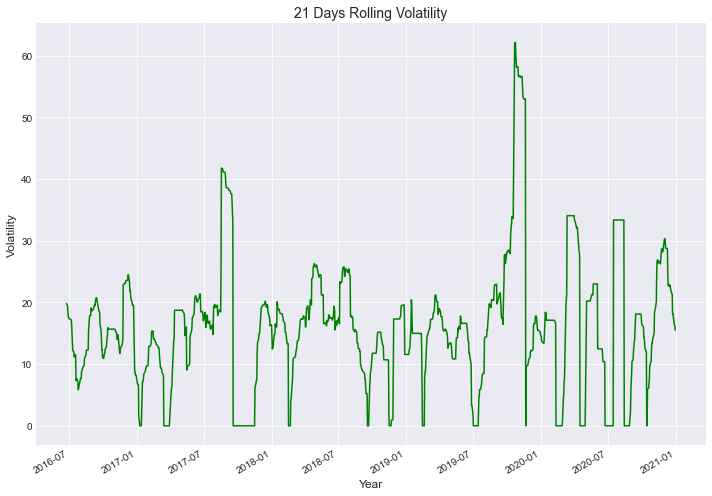

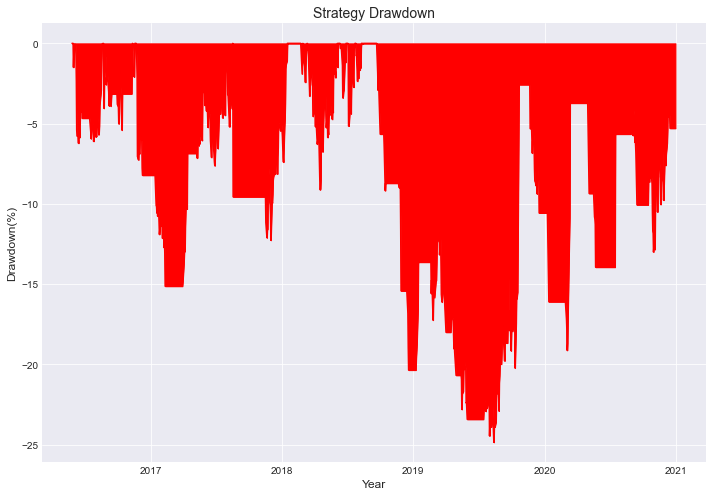

Risk & Returns Metric
Cumulative Return                    20.29%
Annualised Return                     4.13%
Annualised Volatility                18.98%
Maximum Drawdown                    -24.86%
Win Rate                              40.62
Profit Factor                          1.31
Sharpe Ratio                           0.31


William %R strategy with Power Spike for INFOSYS
---------------------------------------------------------------------



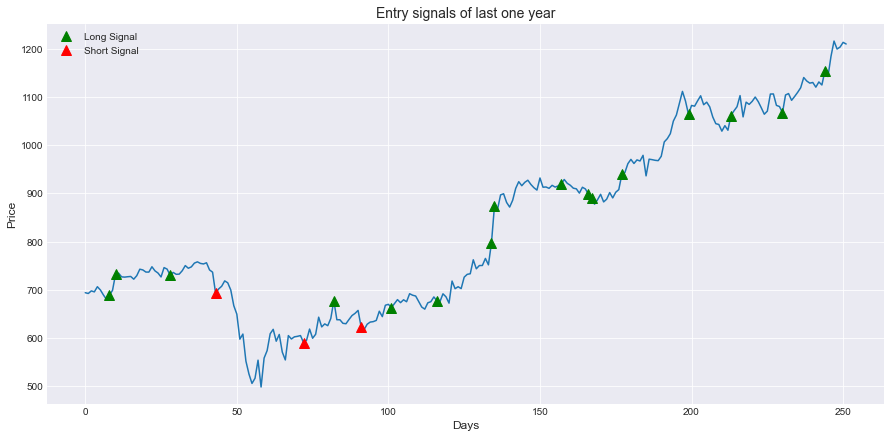

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 37
Avg holding Days                 29
Med holding Days                 24
Max holding Days                 63
Min holding Days                  1

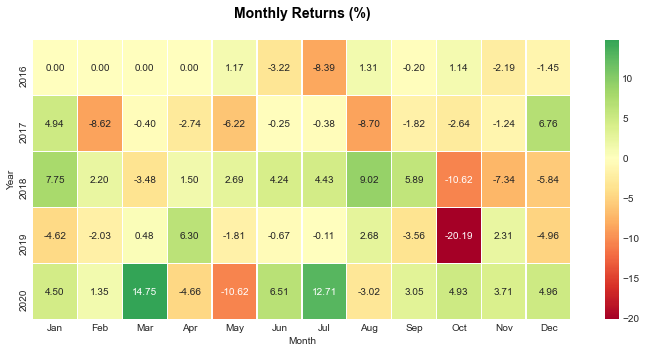

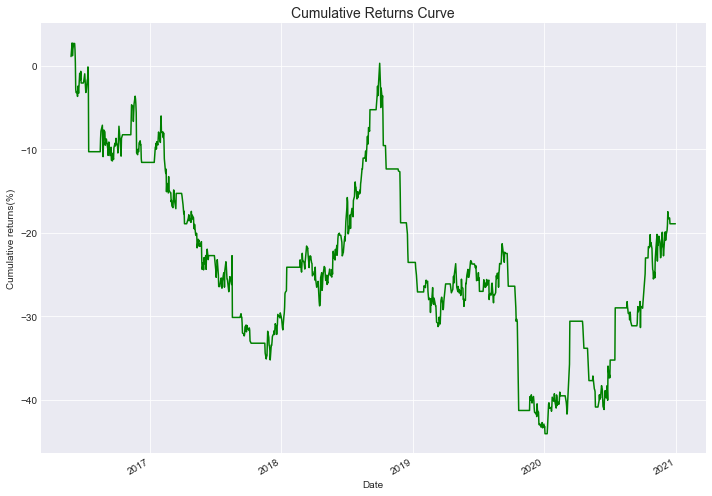

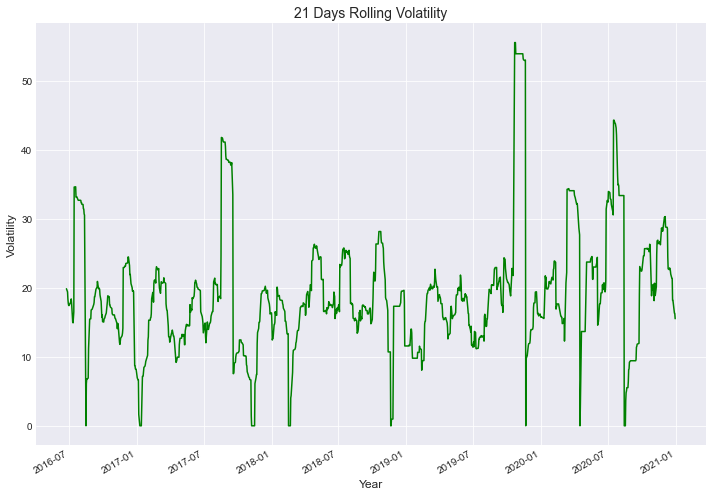

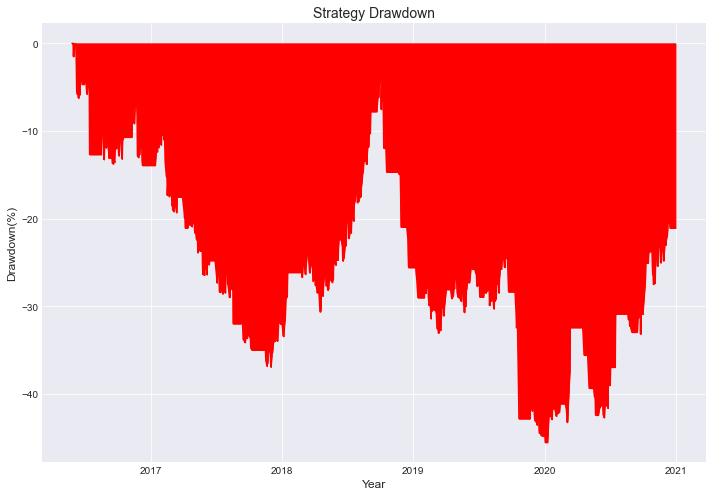

Risk & Returns Metric
Cumulative Return                   -18.92%
Annualised Return                    -4.49%
Annualised Volatility                20.97%
Maximum Drawdown                    -45.50%
Win Rate                              37.84
Profit Factor                          0.87
Sharpe Ratio                          -0.12


Stochatic Oscillator strategy with Power Spike for INFOSYS
---------------------------------------------------------------------



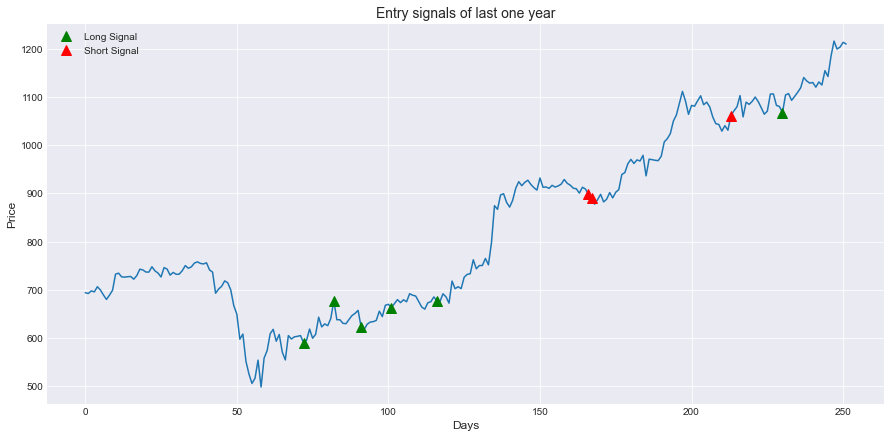

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 25
Avg holding Days                 18
Med holding Days                 14
Max holding Days                 61
Min holding Days                  1

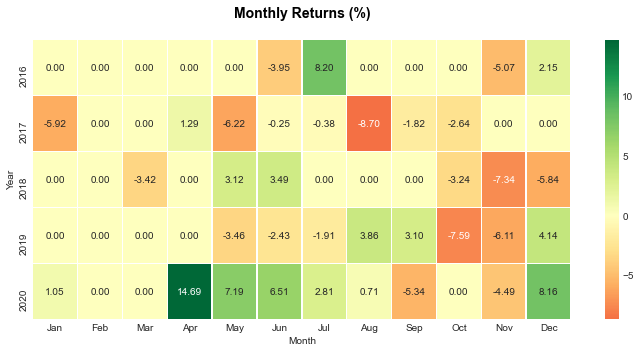

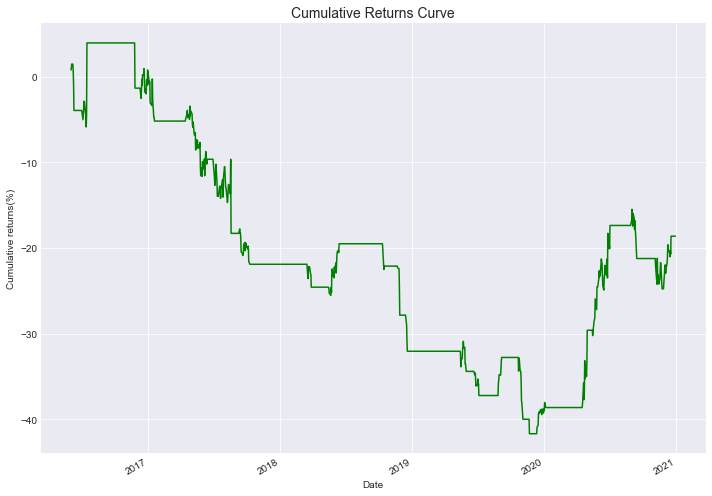

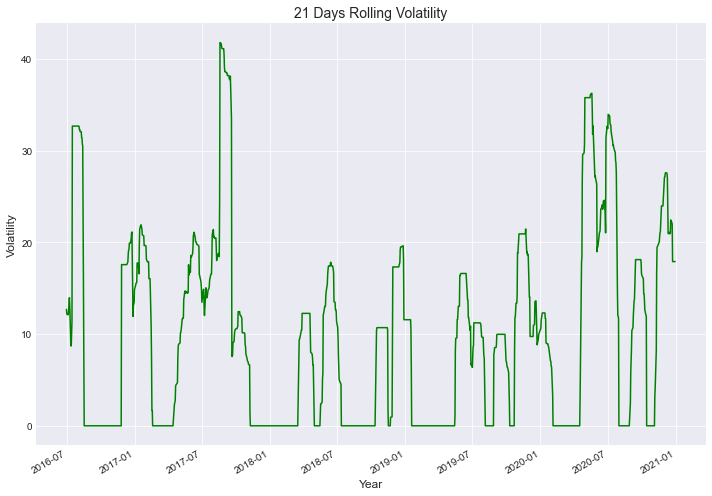

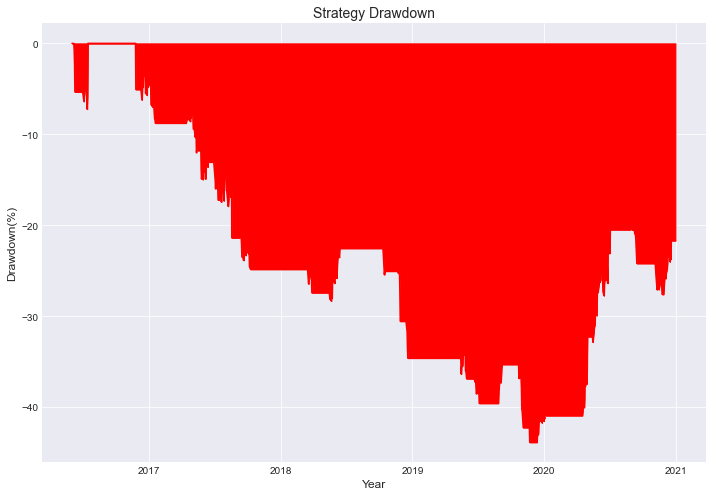

Risk & Returns Metric
Cumulative Return                   -18.62%
Annualised Return                    -4.41%
Annualised Volatility                14.39%
Maximum Drawdown                    -43.87%
Win Rate                               32.0
Profit Factor                          0.79
Sharpe Ratio                          -0.25


RSI indicator strategy with Power Spike for INFOSYS
---------------------------------------------------------------------



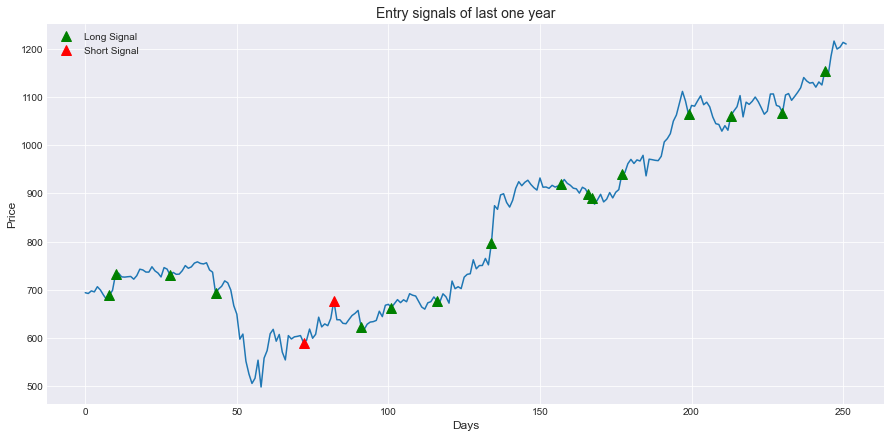

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 38
Avg holding Days                 27
Med holding Days                 21
Max holding Days                 63
Min holding Days                  1

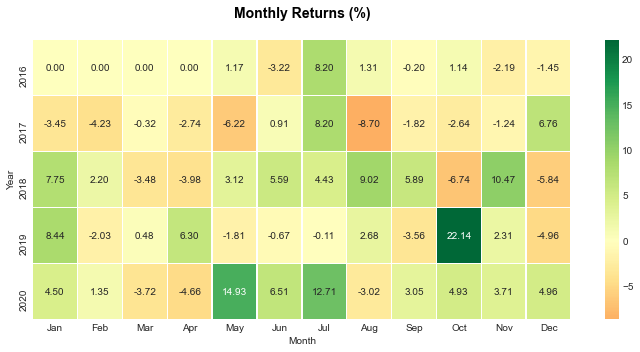

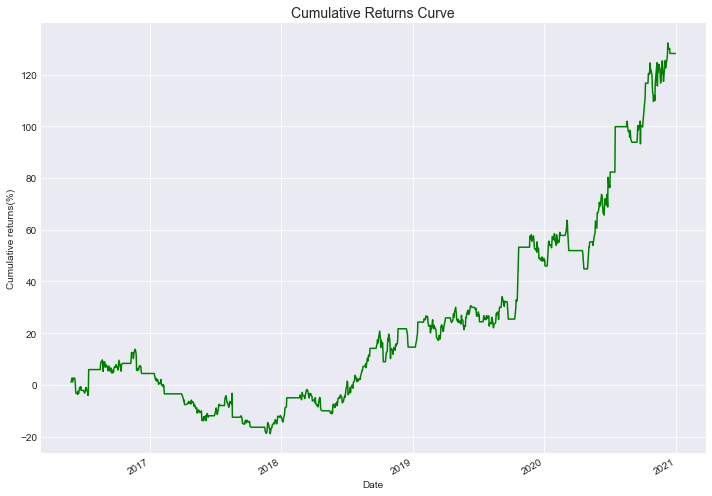

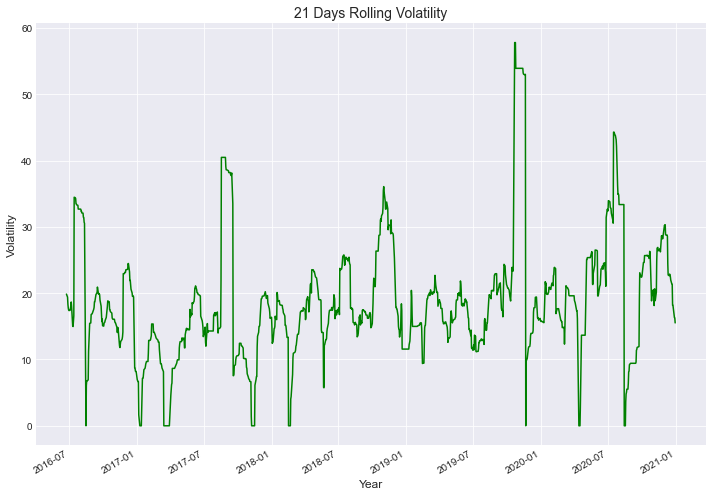

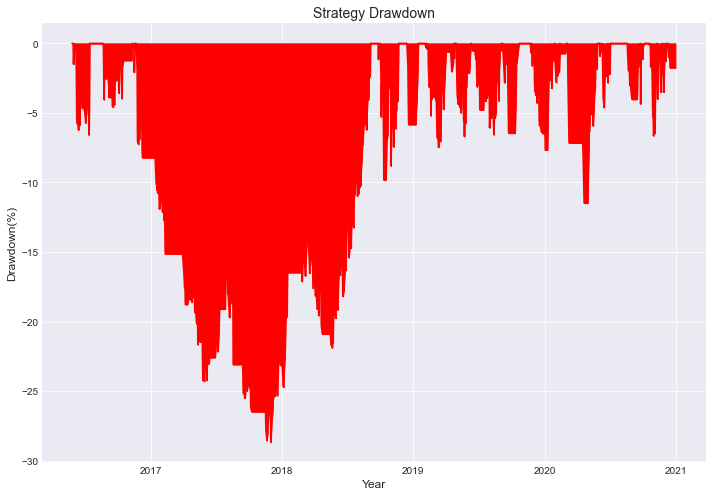

Risk & Returns Metric
Cumulative Return                   128.15%
Annualised Return                    19.81%
Annualised Volatility                20.62%
Maximum Drawdown                    -28.68%
Win Rate                              52.63
Profit Factor                          2.24
Sharpe Ratio                           0.99


Power Spike Competitor strategy for INFOSYS
---------------------------------------------------------------------



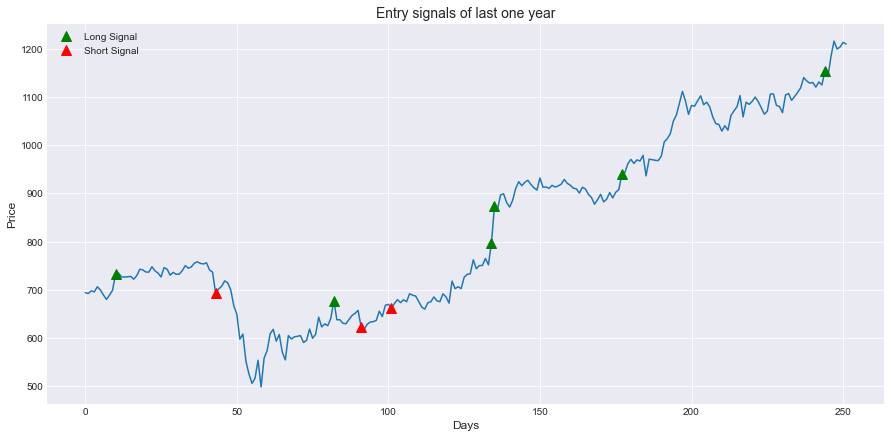

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 21
Avg holding Days                 24
Med holding Days                 15
Max holding Days                 63
Min holding Days                  1

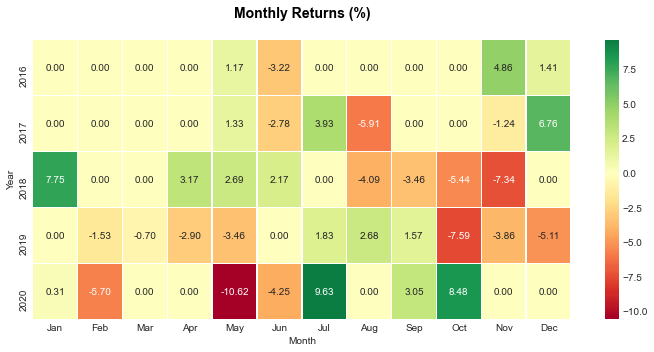

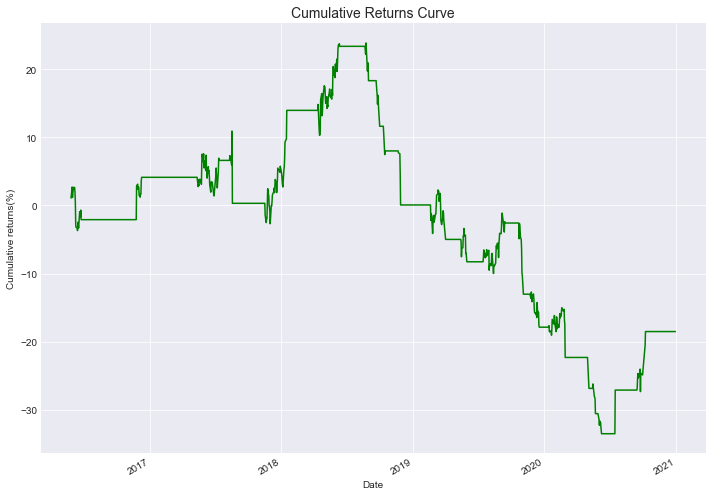

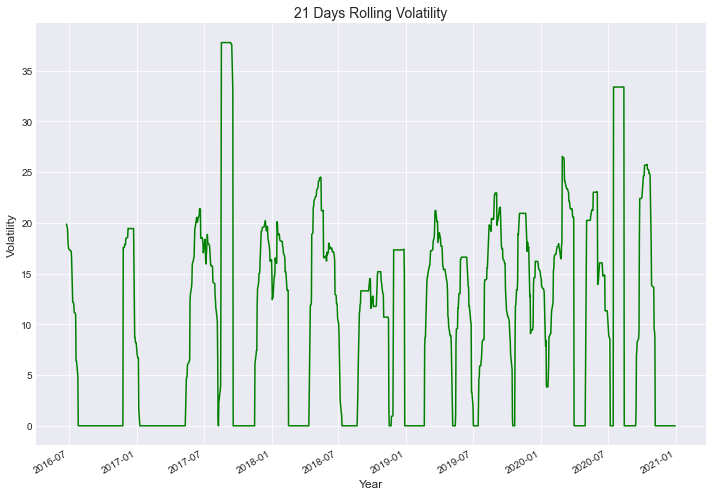

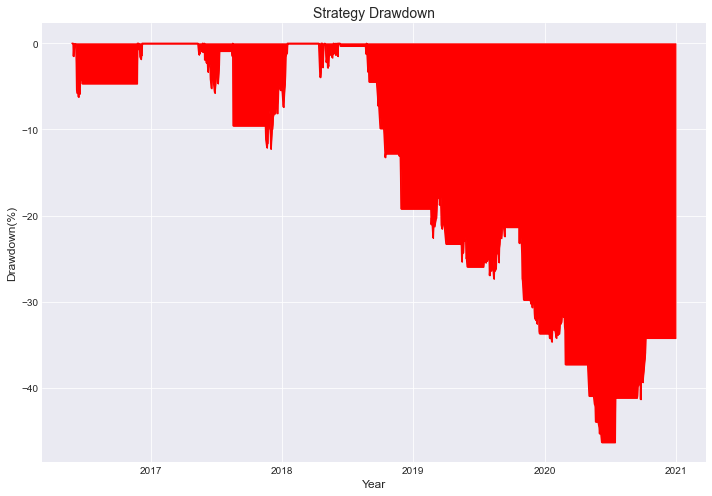

Risk & Returns Metric
Cumulative Return                   -18.51%
Annualised Return                    -4.39%
Annualised Volatility                14.22%
Maximum Drawdown                    -46.32%
Win Rate                              33.33
Profit Factor                          0.75
Sharpe Ratio                          -0.25

In [12]:
print("\n-------------------------------------------------------------------")
print("Strategies Analysis for INFOSYS")
print("-------------------------------------------------------------------\n")

# To analyse BolingerBands strategy with Power Spike for INFOSYS
print("\nBolingerBands strategy with Power Spike for INFOSYS")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_infy, "B_signal")

# To analyse William %R strategy with Power Spike for INFOSYS
print("\nWilliam %R strategy with Power Spike for INFOSYS")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_infy, "W_signal")

# To analyse Stochastic oscillator strategy with Power Spike for INFOSYS
print("\nStochatic Oscillator strategy with Power Spike for INFOSYS")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_infy, "S_signal")

# To analyse RSI indicator strategy with Power Spike for INFOSYS
print("\nRSI indicator strategy with Power Spike for INFOSYS")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_infy, "R_signal")

# To analyse Power Spike Competitor strategy for INFOSYS
print("\nPower Spike Competitor strategy for INFOSYS")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_infy, "C_signal")


-------------------------------------------------------------------
Strategies Analysis for ICICI BANK
-------------------------------------------------------------------


BolingerBands strategy with Power Spike for ICICI BANK
---------------------------------------------------------------------



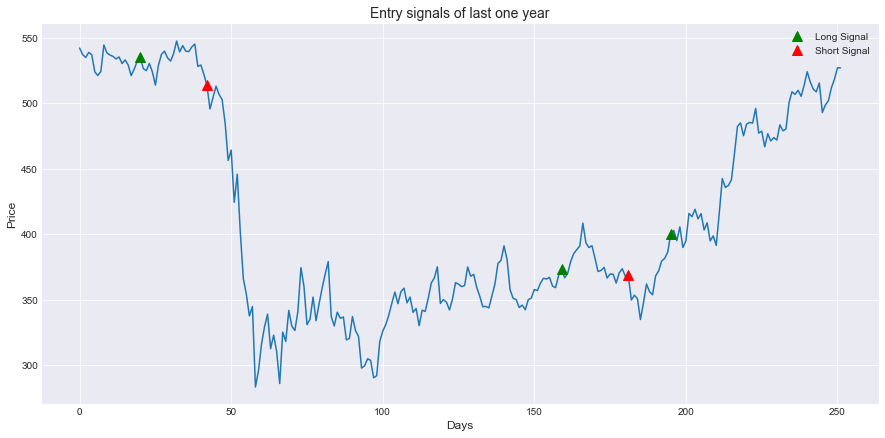

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 31
Avg holding Days                 24
Med holding Days                 20
Max holding Days                 62
Min holding Days                  2

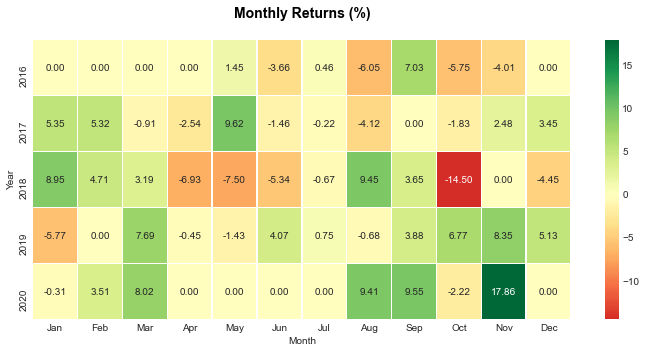

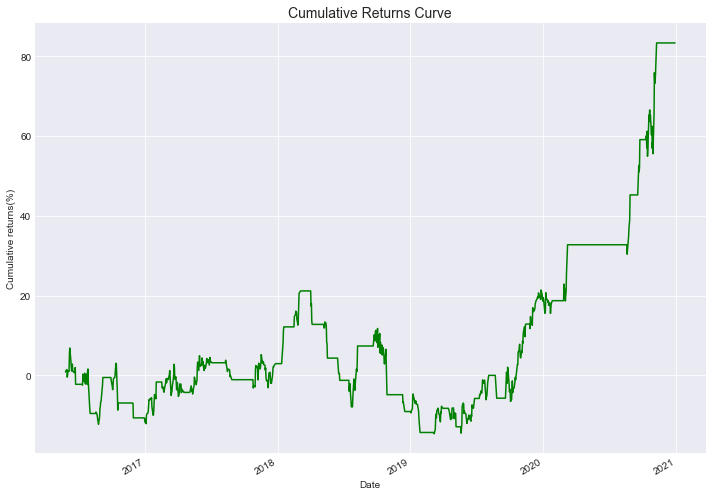

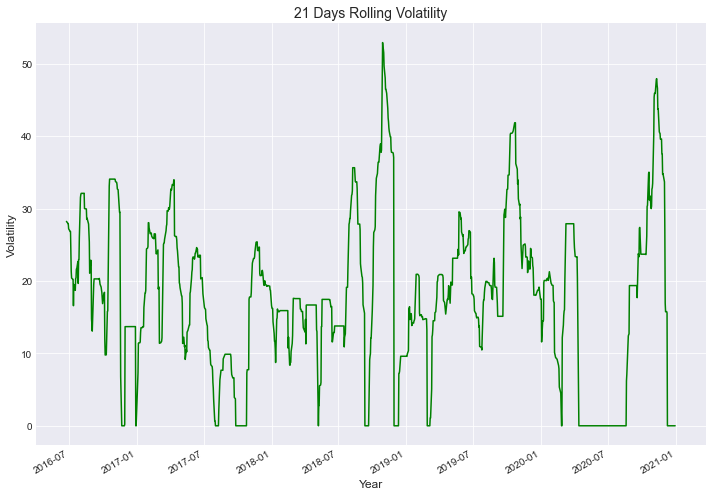

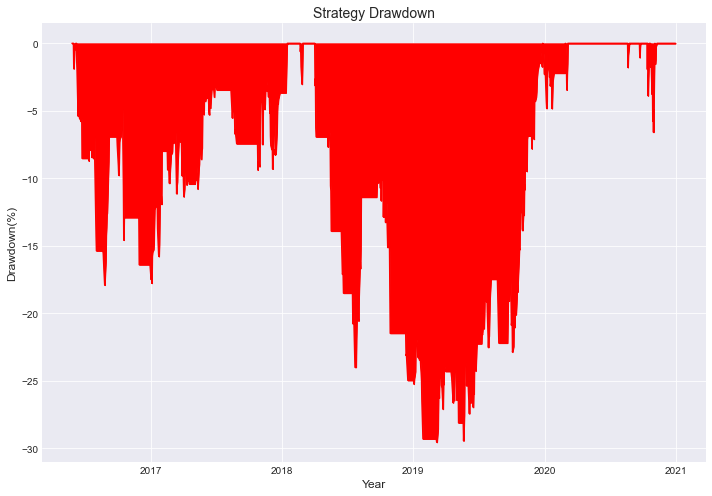

Risk & Returns Metric
Cumulative Return                    83.36%
Annualised Return                    14.21%
Annualised Volatility                20.70%
Maximum Drawdown                    -29.56%
Win Rate                              51.61
Profit Factor                          1.82
Sharpe Ratio                           0.75


William %R strategy with Power Spike for ICICI BANK
---------------------------------------------------------------------



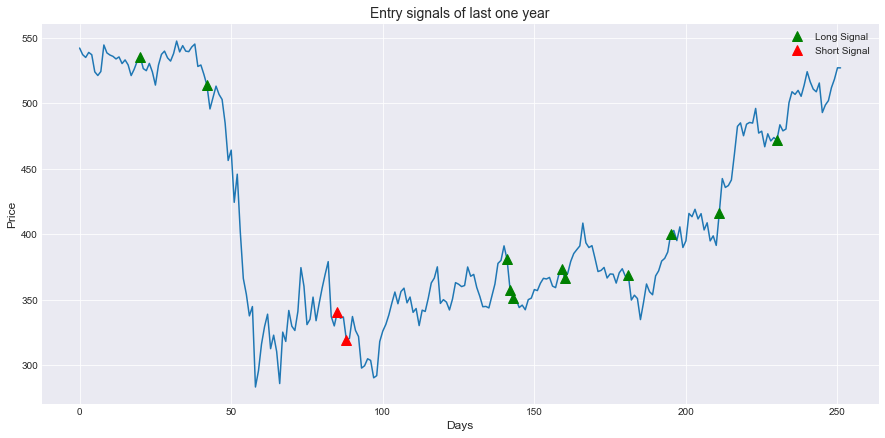

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 38
Avg holding Days                 23
Med holding Days                 21
Max holding Days                 62
Min holding Days                  1

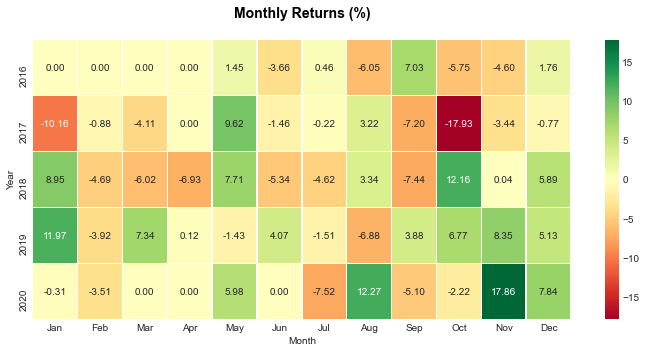

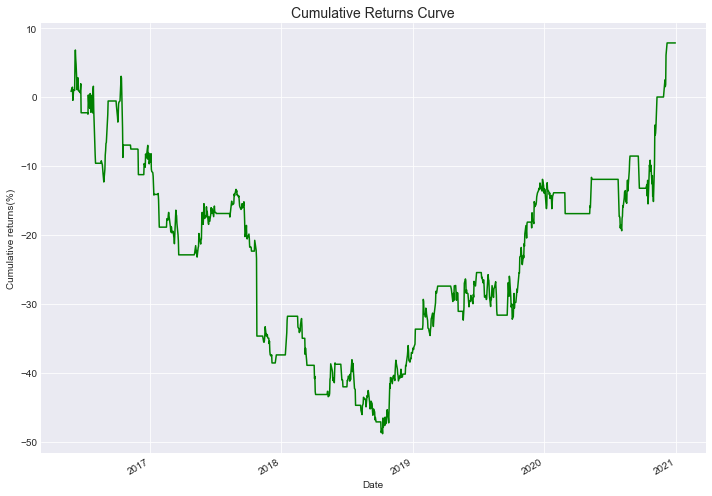

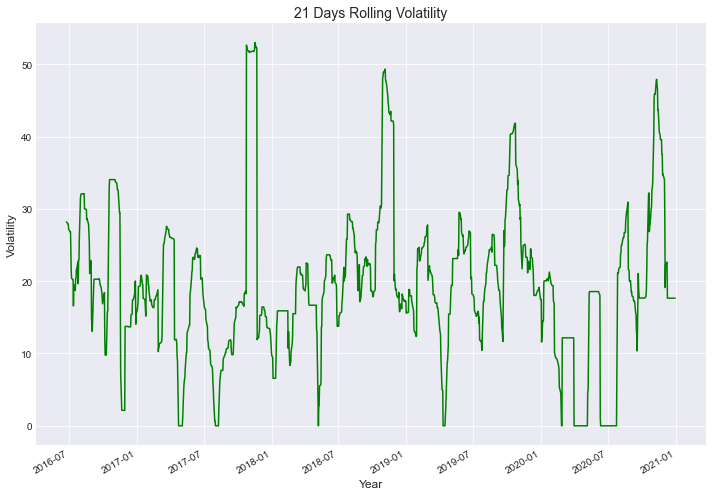

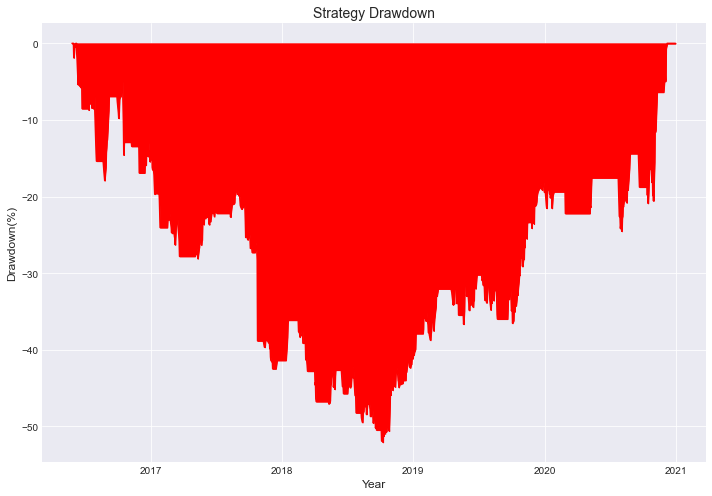

Risk & Returns Metric
Cumulative Return                     7.87%
Annualised Return                     1.67%
Annualised Volatility                22.04%
Maximum Drawdown                    -52.08%
Win Rate                              39.47
Profit Factor                          1.11
Sharpe Ratio                           0.19


Stochastic Oscillator strategy with Power Spike for ICICI BANK
---------------------------------------------------------------------



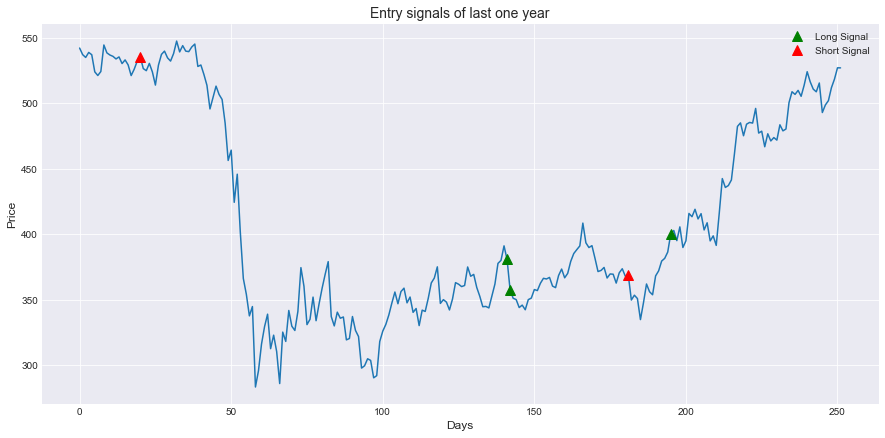

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 25
Avg holding Days                 20
Med holding Days                 21
Max holding Days                 60
Min holding Days                  1

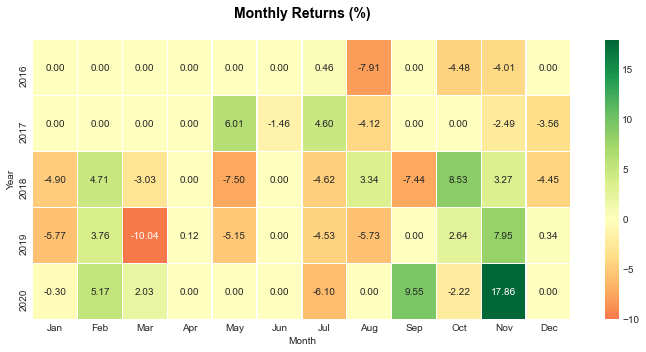

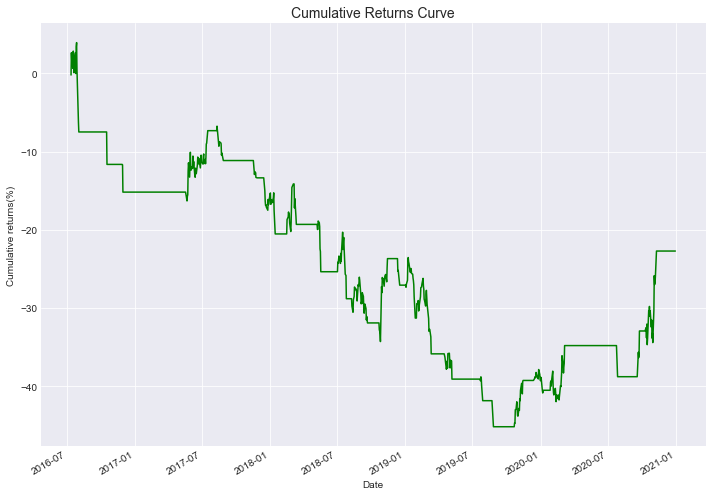

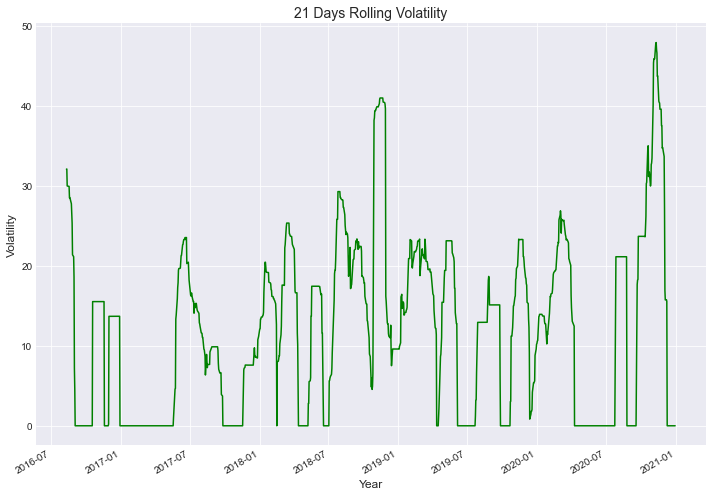

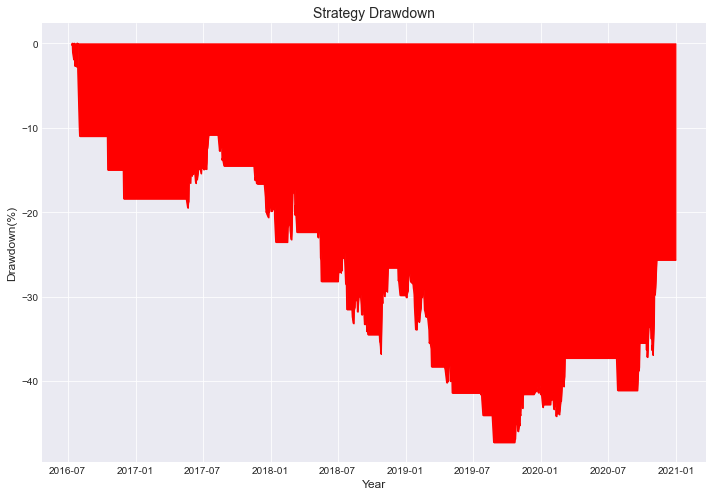

Risk & Returns Metric
Cumulative Return                   -22.71%
Annualised Return                    -5.49%
Annualised Volatility                16.39%
Maximum Drawdown                    -47.26%
Win Rate                               28.0
Profit Factor                          0.77
Sharpe Ratio                          -0.28


RSI indicator strategy with Power Spike for ICICI BANK
---------------------------------------------------------------------



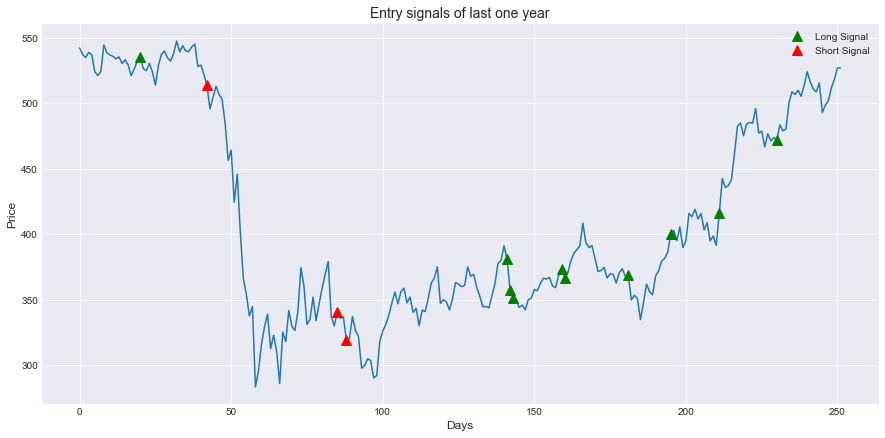

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 41
Avg holding Days                 21
Med holding Days                 19
Max holding Days                 62
Min holding Days                  1

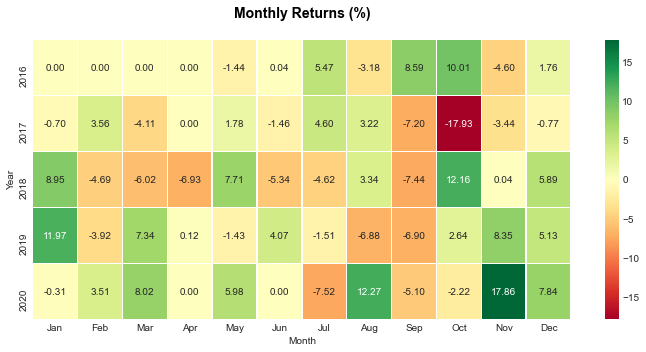

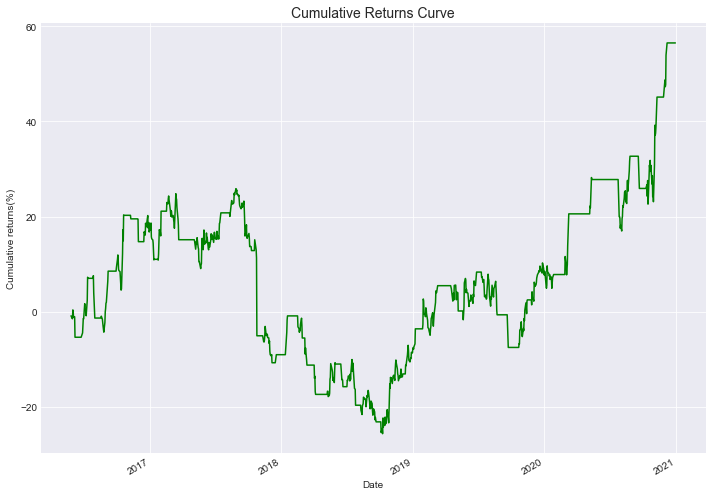

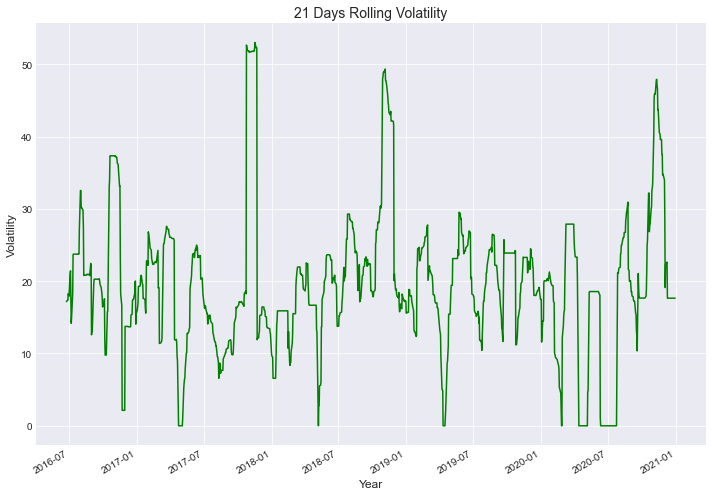

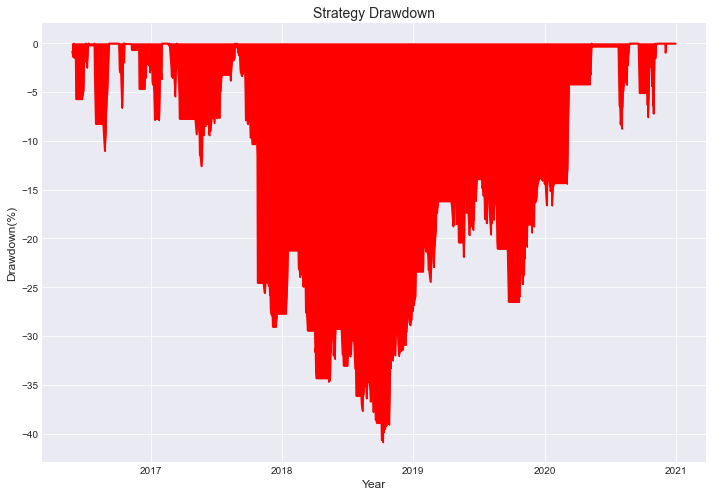

Risk & Returns Metric
Cumulative Return                    56.50%
Annualised Return                    10.31%
Annualised Volatility                21.94%
Maximum Drawdown                    -40.90%
Win Rate                              46.34
Profit Factor                          1.42
Sharpe Ratio                           0.56


Power Spike Competitor strategy ICICI BANK
---------------------------------------------------------------------



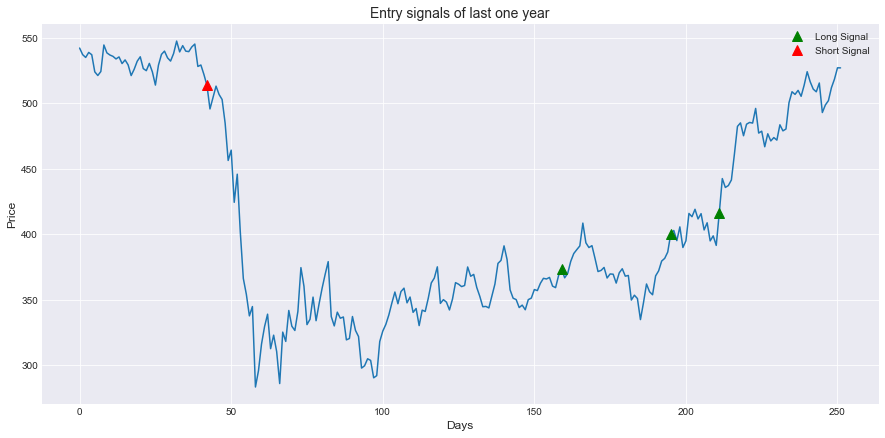

Strategy Backtest
Start Date               2016-05-06
End Date                 2020-12-30
Duration (months)                55
Number of Trades                 26
Avg holding Days                 22
Med holding Days                 19
Max holding Days                 63
Min holding Days                  2

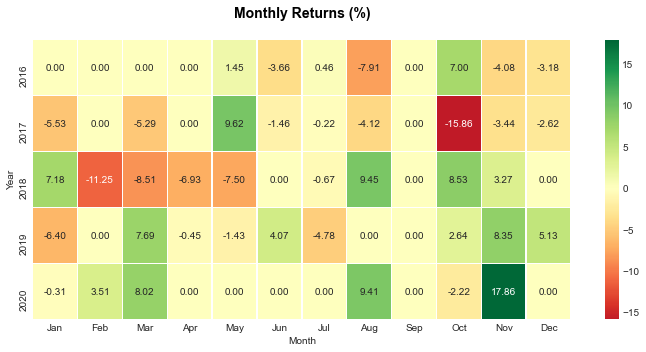

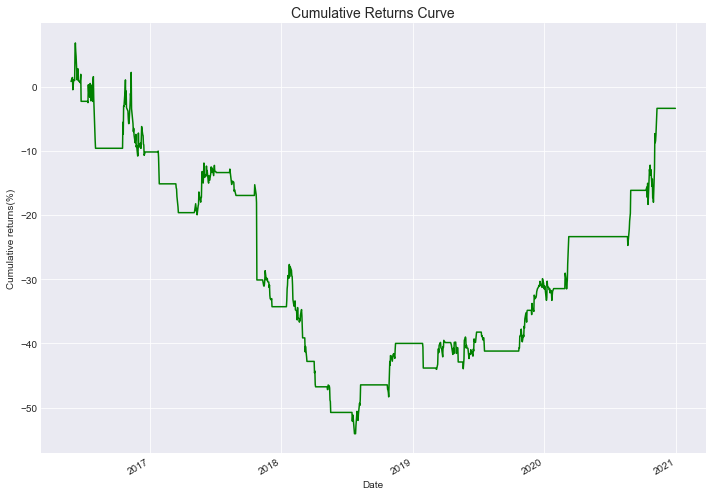

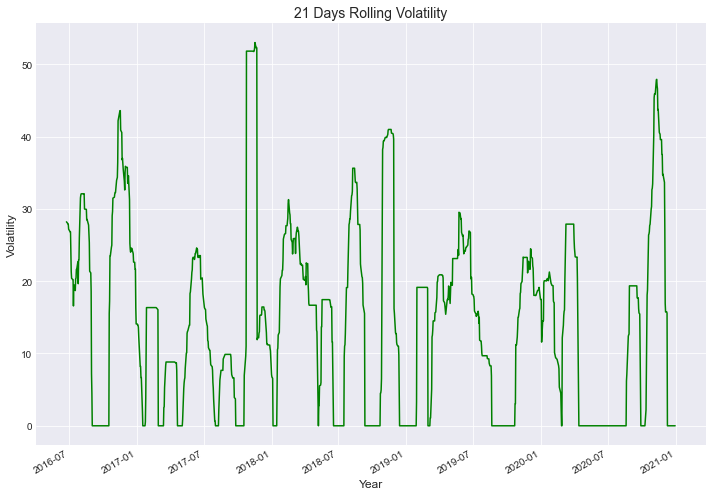

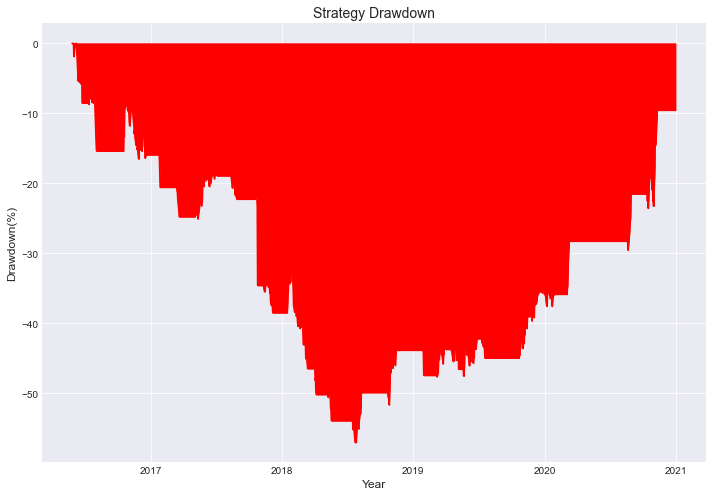

Risk & Returns Metric
Cumulative Return                    -3.35%
Annualised Return                    -0.74%
Annualised Volatility                19.56%
Maximum Drawdown                    -57.02%
Win Rate                              38.46
Profit Factor                          1.01
Sharpe Ratio                           0.06

In [13]:
print("\n-------------------------------------------------------------------")
print("Strategies Analysis for ICICI BANK")
print("-------------------------------------------------------------------\n")

# To analyse BolingerBands strategy with Power Spike for ICICI BANK
print("\nBolingerBands strategy with Power Spike for ICICI BANK")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_icicibank, "B_signal")

# To analyse William %R strategy with Power Spike for ICICI BANK
print("\nWilliam %R strategy with Power Spike for ICICI BANK")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_icicibank, "W_signal")

# To analyse Stochastic oscillator strategy with Power Spike for ICICI BANK
print("\nStochastic Oscillator strategy with Power Spike for ICICI BANK")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_icicibank, "S_signal")

# To analyse RSI indicator strategy with Power Spike for ICICI BANK
print("\nRSI indicator strategy with Power Spike for ICICI BANK")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_icicibank, "R_signal")

# To analyse Power Spike Competitor strategy for ICICI BANK
print("\nPower Spike Competitor strategy ICICI BANK")
print("---------------------------------------------------------------------\n")
strategy_analysis(data_icicibank, "C_signal")